# Репликация простой модели Linear Expenditure System
Данная работа является репликацией учебного примера из видео "Estimating the Linear Expenditure System in R "

Сссылка:https://www.youtube.com/watch?v=F68uDaaPjQA

Реплицировано на основе: https://github.com/EconJohn/Linear-Expenditure-System 

Данные по канадским домохозяйствам: https://www150.statcan.gc.ca/t1/tbl1/en/cv.action?pid=3610022501

## Загрузка библиотек

In [57]:
#Нужна библиотека для чтения CSV
#Библиотека для работы с датафреймами
import pandas as pd
#Для простой регрессии
import statsmodels.formula.api as smf
#Для графиков
import matplotlib.pyplot as plt
#Нам нужен упорядоченный словарь для системы уравнений
from collections import OrderedDict
#Понадобится для добавления константы
import statsmodels.api as sm
#Для оценки систем одновременных уравнений
from linearmodels.system import SUR

## Работа с данными

In [58]:
#Загрузка Датафрейма
#ОБРАТИТЕ ВНИМАНИЕ, ЧТО В СЕПАРИРУЮЩИЙ ЗНАК = 	, Т.Е. ТАБУЛЯЦИЯ
#Подготовка данных
Canada = pd.read_csv(r'C:\Users\79618\Desktop\LES\Canada.txt', sep="	")
Canada=Canada.rename(columns={'Unnamed: 0': "Time"})
Canada=Canada.rename(columns={'Housing water electricity gas and other fuels': "Housing"})
Canada=Canada.rename(columns={'Water supply and sanitation services': "Water"})
Canada=Canada.rename(columns={'Paid rental fees for housing': "Paid_rental_fees"})
Canada=Canada.rename(columns={'Imputed rental fees for housing': "Imputed_rental_fees"})
Canada=Canada.rename(columns={'Materials for the maintenance and repair of the dwelling': "Materials_maintenance"})
Canada=Canada.rename(columns={'Services for the maintenance and repair of the dwelling': "Services_maintenance"})
Canada=Canada.rename(columns={'Other fuels': "Other_fuels"})
Canada

,Time,Housing,Paid_rental_fees,Imputed_rental_fees,Materials_maintenance,Services_maintenance,Water,Electricity,Gas,Other_fuels
0,1981,40096.0,9027.0,22794.0,644.0,35.0,666.0,3004.0,1552.0,2374.0
1,1982,45755.0,10290.0,25818.0,669.0,41.0,760.0,3452.0,2014.0,2711.0
2,1983,50456.0,11489.0,28798.0,708.0,42.0,843.0,3894.0,2244.0,2438.0
3,1984,54417.0,12367.0,31197.0,742.0,47.0,906.0,4400.0,2372.0,2386.0
4,1985,58557.0,13145.0,33667.0,802.0,51.0,966.0,4796.0,2572.0,2558.0
5,1986,62593.0,14114.0,36686.0,905.0,57.0,1059.0,5157.0,2476.0,2139.0
6,1987,66982.0,15245.0,39963.0,967.0,64.0,1150.0,5373.0,2330.0,1890.0
7,1988,73593.0,16582.0,43898.0,1009.0,72.0,1286.0,6166.0,2552.0,2028.0
8,1989,81163.0,18377.0,48658.0,1066.0,88.0,1457.0,6789.0,2560.0,2168.0
9,1990,87712.0,19989.0,52709.0,1076.0,98.0,1618.0,7308.0,2580.0,2334.0


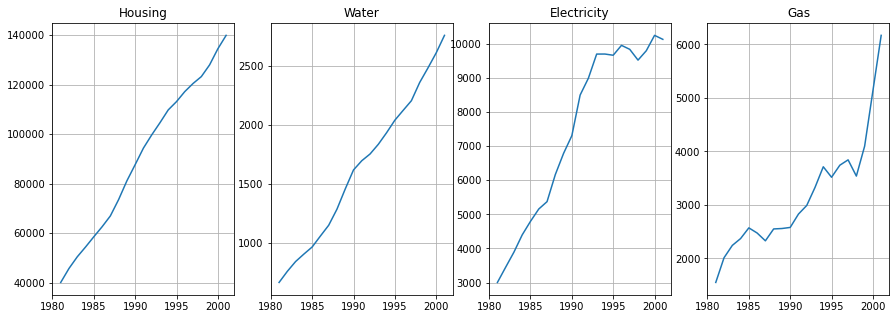

In [60]:
fig,axs=plt.subplots(1,4,figsize = (15, 5))
for i in range(4):
    axs[i].plot("Time",Canada.columns[[1,6,7,8,9][i]],data=Canada)
    axs[i].set(title=Canada.columns[[1,6,7,8,9][i]])
    axs[i].grid()

## Статистическая оценка

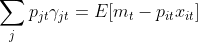

In [61]:
#Step2: Estimate of essential expenditure by obtaining fitted values over time
#Оценка абсолютно необходимых расходов (ниже которых нельзя потреблять)
reg=smf.ols(formula='Housing~Time',data=Canada)
results=reg.fit()

In [101]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                Housing   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     3081.
Date:                Fri, 12 Aug 2022   Prob (F-statistic):           1.73e-22
Time:                        22:50:02   Log-Likelihood:                -193.31
No. Observations:                  21   AIC:                             390.6
Df Residuals:                      19   BIC:                             392.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -9.989e+06   1.82e+05    -55.004      0.0

In [95]:
#Добавим эти fitted values в датафреймы
acon=results.fittedvalues
Canada['detrended']=Canada['Housing']-acon
Canada['Acon']=acon
Canada.head()

,const,Time,Housing,Paid_rental_fees,Imputed_rental_fees,Materials_maintenance,Services_maintenance,Water,Electricity,Gas,Other_fuels,detrended,Acon
0,1.0,1981,40096.0,9027.0,22794.0,644.0,35.0,666.0,3004.0,1552.0,2374.0,-74.658009,40170.658009
1,1.0,1982,45755.0,10290.0,25818.0,669.0,41.0,760.0,3452.0,2014.0,2711.0,521.560173,45233.439827
2,1.0,1983,50456.0,11489.0,28798.0,708.0,42.0,843.0,3894.0,2244.0,2438.0,159.778355,50296.221645
3,1.0,1984,54417.0,12367.0,31197.0,742.0,47.0,906.0,4400.0,2372.0,2386.0,-942.003463,55359.003463
4,1.0,1985,58557.0,13145.0,33667.0,802.0,51.0,966.0,4796.0,2572.0,2558.0,-1864.785281,60421.785281


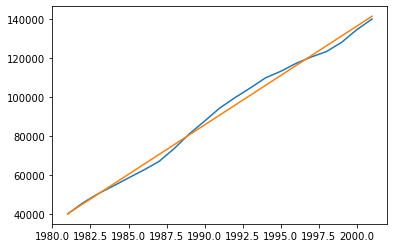

In [64]:
plt.plot("Time","Housing",data=Canada)
plt.plot(Canada["Time"],acon)

Далее проведелем оценку методом **Seemingly Unrelated Regressions (SUR)**

In [100]:
#Добавим константу
Canada=sm.add_constant(Canada)

**СОВПАЛО С РЕШЕНИЕМ В R!**

In [98]:
equations = OrderedDict()
equations['gasoline'] = {'dependent': Canada.Gas,
                         'exog': Canada[[ 'const','detrended']]}
equations['electricity'] = {'dependent': Canada.Electricity,
                         'exog': Canada[[ 'const','detrended']]}
equations['water'] = {'dependent': Canada.Water,
                         'exog': Canada[[ 'const','detrended']]}
mod = SUR(equations)

In [99]:
print(mod.fit(cov_type='unadjusted'))

                           System GLS Estimation Summary                           
Estimator:                        GLS   Overall R-squared:                   0.0512
No. Equations.:                     3   McElroy's R-squared:                 0.3049
No. Observations:                  21   Judge's (OLS) R-squared:             0.0512
Date:                Fri, Aug 12 2022   Berndt's R-squared:                  0.5682
Time:                        22:49:30   Dhrymes's R-squared:                 0.0512
                                        Cov. Estimator:                  unadjusted
                                        Num. Constraints:                      None
                 Equation: gasoline, Dependent Variable: Gas                  
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          3150.6     229.18     13.747     0.0000      2701.4      3599.8
detrended   

**Интерпритация результатов:**

3150 (млн.$)- subsistence consumption ГАЗА в Канаде (Значима с почти нулевой p-value)

-0.0353 - снижение потребление газа по мере роста ????? (инфириорное блего, мало значима)

## Расширения модели

### Модель без цен

https://showdata.gks.ru/olap2/descr/report/273820 - Индексы потребительских цен на товары и услуги в группировке Классификатора индивидуального потребления по целям (КИПЦ)

https://rosstat.gov.ru/compendium/document/13271

Определяем *encoding*, чтобы предотвратить ошибку:
    
**UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position ...**

In [307]:
with open(r'C:\Users\79618\Downloads\Russia.csv') as f:
    print(f)

<_io.TextIOWrapper name='C:\\Users\\79618\\Downloads\\Russia.csv' mode='r' encoding='cp1251'>


In [242]:
Russia = pd.read_csv(r'C:\Users\79618\Downloads\Russia.csv', sep="," ,encoding='cp1251',header=1)

In [308]:
with open(r'C:\Users\79618\Desktop\(3 курс) Курсовая работа\Data\ИНДЕКСЫ ЦЕН (ПО КВАРТАЛАМ).csv') as f:
    print(f)

<_io.TextIOWrapper name='C:\\Users\\79618\\Desktop\\(3 курс) Курсовая работа\\Data\\ИНДЕКСЫ ЦЕН (ПО КВАРТАЛАМ).csv' mode='r' encoding='cp1251'>


In [309]:
Price_index = pd.read_csv(r'C:\Users\79618\Desktop\(3 курс) Курсовая работа\Data\ИНДЕКСЫ ЦЕН (ПО КВАРТАЛАМ).csv', sep="," ,encoding='cp1251',header=2)

In [310]:
Price_index

,Unnamed: 0,Unnamed: 1,10000 ПРОДУКТЫ ПИТАНИЯ И БЕЗАЛКОГОЛЬНЫЕ НАПИТКИ,100000 ОБРАЗОВАНИЕ,1000000 ВСЕ ТОВАРЫ И УСЛУГИ,"1001 Маргарин, кг",101000 Дошкольное и начальное образование (У),102000 Основное общее и среднее (полное) общее образование (У),103000 Среднее профессиональное образование (У),104000 Высшее профессиональное образование (У),...,"9941 Обучение в негосударственных образовательных организациях высшего профессионального образования, семестр","9942 Обучение в государственных и муниципальных образовательных организациях высшего профессионального образования, семестр","9991 Повторное получение гербового документа в органах ЗАГС, документ","9992 Ксерокопирование документа, лист","9993 Пользование общественным туалетом, посещение",w2:p_kipc:150081 Приправы и пряности,w2:p_kipc:160000 ИПЦ без учета взносов на капитальный ремонт,"w2:p_kipc:2005 Соль йодированная пищевая, кг","w2:p_kipc:201 Колбаса вареная, кг",w2:p_kipc:91413 Другие носители для записи звука и изображения
0,11521100300010200003 Индексы потребительских ц...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1 кв. 2011 г.,NaN,"106,43","100,58","104,13","105,06",NaN,"100,67","100,5","100,3",...,"100,53","100,2",100,"102,02","102,62",NaN,NaN,NaN,NaN,NaN
2,2 кв. 2011 г.,NaN,"101,1","100,26","101,5","102,99",NaN,"100,26","100,27","100,15",...,"100,42","100,04",100,"101,41","102,83",NaN,NaN,NaN,NaN,NaN
3,3 кв. 2011 г.,NaN,"97,2","102,68","100,12","101,7",NaN,"102,65","103,23","102,68",...,"101,43","103,17",100,"101,7","102,82",NaN,NaN,NaN,NaN,NaN
4,4 кв. 2011 г.,NaN,"99,85","103,5","100,8","100,99",NaN,"104,95","103,31","103,12",...,"101,39","103,8",100,"101,73","101,4",NaN,NaN,NaN,NaN,NaN
5,1 кв. 2012 г.,NaN,"102,05","100,35","101,38","100,59",NaN,"100,54","100,39","100,21",...,"100,28","100,18",100,"100,81","101,63",NaN,NaN,NaN,NaN,NaN
6,2 кв. 2012 г.,NaN,"101,88","100,33","101,47","100,52",NaN,"100,32","100,15","100,27",...,"100,25","100,27",100,"101,33","101,04",NaN,NaN,NaN,NaN,NaN
7,3 кв. 2012 г.,NaN,"101,79","105,51","102,26","100,46",NaN,"101,64","102,52","107,89",...,"101,86","110,29",100,"101,56","102,22",NaN,NaN,NaN,NaN,NaN
8,4 кв. 2012 г.,NaN,"100,74","105,85","101,27","101,86",NaN,"104,42","103,97","107,11",...,"102,02","108,97",100,"102,33","102,66",NaN,NaN,NaN,NaN,NaN
9,1 кв. 2013 г.,NaN,"102,49","100,34","101,94","101,51",NaN,"100,49","100,35","100,2",...,"100,44","100,12",100,"101,75","102,44",NaN,NaN,NaN,NaN,NaN


In [280]:
Russia.columns[1]

'Unnamed: 1'

In [144]:
Russia=Russia.rename(columns={'Unnamed: 0': "Good"})
Russia

,Good,Unnamed: 1,январь 2010 г.,февраль 2010 г.,март 2010 г.,апрель 2010 г.,май 2010 г.,июнь 2010 г.,июль 2010 г.,август 2010 г.,...,сентябрь 2021 г.,октябрь 2021 г.,ноябрь 2021 г.,декабрь 2021 г.,январь 2022 г.,февраль 2022 г.,март 2022 г.,апрель 2022 г.,май 2022 г.,июнь 2022 г.
0,К предыдущему месяцу,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Российская Федерация,643,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ПРОДУКТЫ ПИТАНИЯ И БЕЗАЛКОГОЛЬНЫЕ НАПИТКИ,10000,"101,5",NaN,"101,04","100,19","100,67","100,57","100,3","101,03",...,"101,17","102,57","101,47","101,59","101,59","101,74","107,24","102,97","100,51","98,63"
3,ОБРАЗОВАНИЕ,100000,"100,47",NaN,"100,11","100,05","100,05","100,02","100,25","101,06",...,"104,33","100,18","100,18","100,03","100,19","100,04","100,17","100,12","100,07","100,08"
4,ВСЕ ТОВАРЫ И УСЛУГИ,1000000,"101,64",NaN,"100,63","100,29","100,5","100,39","100,36","100,55",...,"100,6","101,11","100,96","100,82","100,99","101,17","107,61","101,56","100,12","99,65"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1342,Приправы и пряности,w2:p_kipc:150081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"100,64","100,57","100,86","100,81","100,92","101,25","106,74","106,12","103,18","101,43"
1343,ИПЦ без учета взносов на капитальный ремонт,w2:p_kipc:160000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"100,61","101,11","100,96","100,83","100,93","101,17","107,67","101,57","100,12","99,64"
1344,"Соль йодированная пищевая, кг",w2:p_kipc:2005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1345,"Колбаса вареная, кг",w2:p_kipc:201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"100,87","101,27","101,36","101,45","100,4","100,61","102,86","103,75","100,94","100,11"


In [153]:
big_categories=[]
for i in range(len(Russia.Good)):
    if Russia.Good[i].isupper():
        print(i,Russia.Good[i])
        big_categories.append(i)

2 ПРОДУКТЫ ПИТАНИЯ И БЕЗАЛКОГОЛЬНЫЕ НАПИТКИ
3 ОБРАЗОВАНИЕ
4 ВСЕ ТОВАРЫ И УСЛУГИ
15 ГОСТИНИЦЫ, КАФЕ И РЕСТОРАНЫ
190 ДРУГИЕ ТОВАРЫ И УСЛУГИ
418 АЛКОГОЛЬНЫЕ НАПИТКИ, ТАБАЧНЫЕ ИЗДЕЛИЯ
485 ОДЕЖДА И ОБУВЬ
575 ЖИЛИЩНЫЕ УСЛУГИ, ВОДА, ЭЛЕКТРОЭНЕРГИЯ, ГАЗ И ДРУГИЕ ВИДЫ ТОПЛИВА
733 ПРЕДМЕТЫ ДОМАШНЕГО ОБИХОДА, БЫТОВАЯ ТЕХНИКА И ПОВСЕДНЕВНЫЙ УХОД ЗА ДОМОМ
851 ЗДРАВООХРАНЕНИЕ
923 ТРАНСПОРТ
1087 СВЯЗЬ
1129 ОРГАНИЗАЦИЯ ОТДЫХА И КУЛЬТУРНЫЕ МЕРОПРИЯТИЯ


In [158]:
Russia.loc[big_categories]

,Good,Unnamed: 1,январь 2010 г.,февраль 2010 г.,март 2010 г.,апрель 2010 г.,май 2010 г.,июнь 2010 г.,июль 2010 г.,август 2010 г.,...,сентябрь 2021 г.,октябрь 2021 г.,ноябрь 2021 г.,декабрь 2021 г.,январь 2022 г.,февраль 2022 г.,март 2022 г.,апрель 2022 г.,май 2022 г.,июнь 2022 г.
2,ПРОДУКТЫ ПИТАНИЯ И БЕЗАЛКОГОЛЬНЫЕ НАПИТКИ,10000,"101,5",NaN,"101,04","100,19","100,67","100,57","100,3","101,03",...,"101,17","102,57","101,47","101,59","101,59","101,74","107,24","102,97","100,51","98,63"
3,ОБРАЗОВАНИЕ,100000,"100,47",NaN,"100,11","100,05","100,05","100,02","100,25","101,06",...,"104,33","100,18","100,18","100,03","100,19","100,04","100,17","100,12","100,07","100,08"
4,ВСЕ ТОВАРЫ И УСЛУГИ,1000000,"101,64",NaN,"100,63","100,29","100,5","100,39","100,36","100,55",...,"100,6","101,11","100,96","100,82","100,99","101,17","107,61","101,56","100,12","99,65"
15,"ГОСТИНИЦЫ, КАФЕ И РЕСТОРАНЫ",110000,"100,59",NaN,"100,76","100,52","100,68","100,33","100,39","100,59",...,"100,56","100,66","100,14","100,54","100,58","100,51","104,15","102,73","101,03","100,64"
190,ДРУГИЕ ТОВАРЫ И УСЛУГИ,120000,"100,98",NaN,"100,58","100,55","100,38","100,34","100,32","100,38",...,"100,61","100,51","100,65","100,57","101,14","101,25","112,63","103,02","99,7","99,47"
418,"АЛКОГОЛЬНЫЕ НАПИТКИ, ТАБАЧНЫЕ ИЗДЕЛИЯ",20000,"101,36",NaN,"101,16","100,89","100,83","100,49","100,44","100,55",...,"100,17","100,36","100,13","100,32","100,71","100,67","103,07","101,62","100,95","100,37"
485,ОДЕЖДА И ОБУВЬ,30000,"100,37",NaN,"100,57","100,46","100,35","100,25","100,2","100,41",...,"100,63","100,62","100,34","100,28","99,99","100,23","105,1","101,13","100,26","99,9"
575,"ЖИЛИЩНЫЕ УСЛУГИ, ВОДА, ЭЛЕКТРОЭНЕРГИЯ, ГАЗ И Д...",40000,"108,13",NaN,"100,1","100,2","100,08","100,14","100,18","100,23",...,"100,02","100,13","100,23","100,09","100,58","100,81","101,65","100,18","100,09","99,75"
733,"ПРЕДМЕТЫ ДОМАШНЕГО ОБИХОДА, БЫТОВАЯ ТЕХНИКА И ...",50000,"100,41",NaN,"100,31","100,24","100,15","100,12","100,16","100,25",...,"100,89","100,72","100,71","100,83","100,72","101,19","114,7","100,25","100,23","99,69"
851,ЗДРАВООХРАНЕНИЕ,60000,"100,48",NaN,"100,22","99,77","99,89","100,31","100,09","100,27",...,"100,27","100,55","100,31","100,27","100,51","100,72","107,16","100,5","100,04","100,01"


In [151]:
Russia.Good[1].isupper()

False

https://rosstat.gov.ru/compendium/document/13271 - 	Уровень и состав располагаемых ресурсов и расходов на потребление домашних хозяйств

In [360]:
Households = pd.read_excel(r'C:\Users\79618\Desktop\(3 курс) Курсовая работа\Data\ДХ.xlsx',header=0)

In [362]:
Households.head()

,Потребление,2007Q1,2007Q2,2007Q3,2007Q4,2008Q1,2008Q2,2008Q3,2008Q4,2009Q1,...,2019Q4,2020Q1,2020Q2,2020Q3,2020Q4,2021Q1,2021Q2,2021Q3,2021Q4,2022Q1
0,ГОД,2007.0,2007.0,2007.0,2007.0,2008.0,2008.0,2008.0,2008.0,2009.0,...,2019.000,2020.000,2020.000,2020.000,2020.00,2021.000,2021.000,2021.000,2021.000,2022.000
1,КВАРТАЛ,1.0,2.0,3.0,4.0,1.0,2.0,3.0,4.0,1.0,...,4.000,1.000,2.000,3.000,4.00,1.000,2.000,3.000,4.000,1.000
2,Располагаемые ресурсы - всего,7418.4,8232.6,9603.3,11373.3,9980.1,11807.3,12671.1,13538.3,11252.3,...,32502.338,27396.751,27943.790,29186.741,32232.68,27580.180,30502.978,34322.594,34315.917,35251.775
3,валовой доход,6853.5,7592.6,8553.7,9963.5,9236.6,10714.7,11460.6,11720.8,10547.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,денежный доход,6478.4,7272.5,8205.7,9538.9,8768.1,10333.0,11042.3,11244.0,10020.5,...,29092.568,24421.272,24670.972,25980.598,28218.39,24754.312,27328.188,28348.126,30903.801,32419.935


In [363]:
HH_transpose=Households.transpose()

In [364]:
HH_transpose

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
Потребление,ГОД,КВАРТАЛ,Располагаемые ресурсы - всего,валовой доход,денежный доход,стоимость натуральных поступлений,сумма привлеченных средств и израсходованных ...,Расходы на конечное потребление- всего,домашнее питание,денежные расходы,...,"гостиницы, кафе и рестораны",другие товары и услуги,"стоимость услуг, предоставленных работодателе...",Потребительские расходы- всего,Справочно: из общей суммы расходов на потребле...,расходы на непродовольственные товары,расходы на алкогольные напитки,расходы на оплату услуг,"стоимость услуг, предоставленных работодателем...","финансовые услуги, услуги страхования"
2007Q1,2007.0,1.0,7418.4,6853.5,6478.4,375.1,564.9,5768.2,1939.0,1627.9,...,139.3,308.5,7.5,5445.7,NaN,NaN,NaN,NaN,NaN,NaN
2007Q2,2007.0,2.0,8232.6,7592.6,7272.5,320.1,640.0,6254.4,2022.0,1760.5,...,203.7,335.6,15.1,5977.4,NaN,NaN,NaN,NaN,NaN,NaN
2007Q3,2007.0,3.0,9603.3,8553.7,8205.7,348.0,1049.6,7099.1,2120.7,1835.7,...,233.1,359.2,13.5,6830.7,NaN,NaN,NaN,NaN,NaN,NaN
2007Q4,2007.0,4.0,11373.3,9963.5,9538.9,424.6,1409.8,8248.5,2462.7,2126.1,...,207.6,419.0,10.6,7909.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021Q1,2021.0,1.0,27580.18,NaN,24754.312,903.31,1922.557,19212.541,6382.719555,5737.699555,...,423.274582,1139.557285,36.506077,18514.584,7108.914,6501.451,299.36,5266.31,36.506077,154.915724
2021Q2,2021.0,2.0,30502.978,NaN,27328.188,788.716,2386.074,20419.658,7012.619,6428.624,...,537.421,1200.582,56.722,19791.086,7496.415,6987.527,292.316,5586.69,56.722,181.924
2021Q3,2021.0,3.0,34322.594,NaN,28348.126,890.401,5084.068,21742.005,7105.832,6412.105,...,683.361,1287.516,73.465,21072.36,7625.406,7802.62,305.049,5935.472,73.465,195.938
2021Q4,2021.0,4.0,34315.917,NaN,30903.801,928.099,2484.017,23024.478,7865.368,7198.082,...,708.373,1413.991,48.374,22427.468,8432.327,8282.488,382.909,5878.416,48.374,284.445


In [367]:
HH_transpose.columns=list(HH_transpose[0:1].values[0])

In [369]:
HH_transpose=HH_transpose[1:]

In [371]:
HH_transpose.head()

,ГОД,КВАРТАЛ,Располагаемые ресурсы - всего,валовой доход,денежный доход,стоимость натуральных поступлений,сумма привлеченных средств и израсходованных сбережений,Расходы на конечное потребление- всего,домашнее питание,денежные расходы,...,"гостиницы, кафе и рестораны",другие товары и услуги,"стоимость услуг, предоставленных работодателем бесплатно или по льготным ценам",Потребительские расходы- всего,Справочно: из общей суммы расходов на потребление: расходы на питание,расходы на непродовольственные товары,расходы на алкогольные напитки,расходы на оплату услуг,"стоимость услуг, предоставленных работодателем бесплатно или по льготным ценам","финансовые услуги, услуги страхования"
2007Q1,2007.0,1.0,7418.4,6853.5,6478.4,375.1,564.9,5768.2,1939.0,1627.9,...,139.3,308.5,7.5,5445.7,NaN,NaN,NaN,NaN,NaN,NaN
2007Q2,2007.0,2.0,8232.6,7592.6,7272.5,320.1,640.0,6254.4,2022.0,1760.5,...,203.7,335.6,15.1,5977.4,NaN,NaN,NaN,NaN,NaN,NaN
2007Q3,2007.0,3.0,9603.3,8553.7,8205.7,348.0,1049.6,7099.1,2120.7,1835.7,...,233.1,359.2,13.5,6830.7,NaN,NaN,NaN,NaN,NaN,NaN
2007Q4,2007.0,4.0,11373.3,9963.5,9538.9,424.6,1409.8,8248.5,2462.7,2126.1,...,207.6,419.0,10.6,7909.0,NaN,NaN,NaN,NaN,NaN,NaN
2008Q1,2008.0,1.0,9980.1,9236.6,8768.1,468.5,743.5,7359.2,2483.1,2115.6,...,227.1,431.8,12.5,6972.3,NaN,NaN,NaN,NaN,NaN,NaN


In [411]:
for i in range(len(HH_transpose.columns)):
    print(i,HH_transpose.columns[i])

0 ГОД
1 КВАРТАЛ
2 Располагаемые ресурсы - всего
3 валовой доход
4 денежный доход
5 стоимость натуральных поступлений
6 сумма привлеченных средств и  израсходованных сбережений
7 Расходы на конечное потребление- всего
8 домашнее питание
9     денежные расходы
10 стоимость натуральных поступлений продуктов питания
11 поступлений из личного подсобного хозяйства
12 полученных подарков и других поступлений
13 алкогольные напитки, табачные    изделия
14 одежду и обувь
15 жилищно-коммунальные услуги и ТОПЛИВО
16 предметы домашнего обихода,    бытовую технику и уход за домом
17 здравоохранение
18 транспорт
19 связь
20 организацию отдыха и культурные    мероприятия
21 образование
22 гостиницы, кафе и рестораны
23 другие товары и услуги
24 стоимость услуг, предоставленных  работодателем бесплатно или по  льготным ценам
25 Потребительские расходы- всего
26 Справочно: из общей суммы расходов на потребление: расходы на питание
27 расходы на непродовольственные товары
28 расходы на алкогольные напит

In [ ]:
#Нам нужны следующие номера 7 по 31

In [415]:
HH_transpose=HH_transpose.iloc[:,range(7,32)]

In [416]:
HH_transpose

,Расходы на конечное потребление- всего,домашнее питание,денежные расходы,стоимость натуральных поступлений продуктов питания,поступлений из личного подсобного хозяйства,полученных подарков и других поступлений,"алкогольные напитки, табачные изделия",одежду и обувь,жилищно-коммунальные услуги и ТОПЛИВО,"предметы домашнего обихода, бытовую технику и уход за домом",...,"гостиницы, кафе и рестораны",другие товары и услуги,"стоимость услуг, предоставленных работодателем бесплатно или по льготным ценам",Потребительские расходы- всего,Справочно: из общей суммы расходов на потребление: расходы на питание,расходы на непродовольственные товары,расходы на алкогольные напитки,расходы на оплату услуг,"стоимость услуг, предоставленных работодателем бесплатно или по льготным ценам","финансовые услуги, услуги страхования"
2007Q1,5768.2,1939.0,1627.9,311.1,255.9,55.2,145.3,518.2,677.6,395.1,...,139.3,308.5,7.5,5445.7,NaN,NaN,NaN,NaN,NaN,NaN
2007Q2,6254.4,2022.0,1760.5,261.5,207.0,54.5,141.1,537.7,725.7,391.6,...,203.7,335.6,15.1,5977.4,NaN,NaN,NaN,NaN,NaN,NaN
2007Q3,7099.1,2120.7,1835.7,285.0,216.2,68.8,151.4,639.4,845.9,503.7,...,233.1,359.2,13.5,6830.7,NaN,NaN,NaN,NaN,NaN,NaN
2007Q4,8248.5,2462.7,2126.1,336.6,272.3,64.3,196.5,1014.5,795.4,612.0,...,207.6,419.0,10.6,7909.0,NaN,NaN,NaN,NaN,NaN,NaN
2008Q1,7359.2,2483.1,2115.6,367.5,295.7,71.8,166.5,693.3,768.0,522.4,...,227.1,431.8,12.5,6972.3,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021Q1,19212.541,6382.719555,5737.699555,645.02,490.456464,154.563536,285.820901,2605.547848,2043.570796,961.188575,...,423.274582,1139.557285,36.506077,18514.584,7108.914,6501.451,299.36,5266.31,36.506077,154.915724
2021Q2,20419.658,7012.619,6428.624,583.995,433.074,150.921,569.997,1378.303,2226.251,1065.495,...,537.421,1200.582,56.722,19791.086,7496.415,6987.527,292.316,5586.69,56.722,181.924
2021Q3,21742.005,7105.832,6412.105,693.727,487.294,206.433,619.041,1805.618,2155.801,1232.345,...,683.361,1287.516,73.465,21072.36,7625.406,7802.62,305.049,5935.472,73.465,195.938
2021Q4,23024.478,7865.368,7198.082,667.286,506.799,160.487,703.314,1980.783,2491.375,1216.956,...,708.373,1413.991,48.374,22427.468,8432.327,8282.488,382.909,5878.416,48.374,284.445


In [429]:
HH_transpose=HH_transpose.astype(float)

In [430]:
HH_transpose

,Расходы на конечное потребление- всего,домашнее питание,денежные расходы,стоимость натуральных поступлений продуктов питания,поступлений из личного подсобного хозяйства,полученных подарков и других поступлений,"алкогольные напитки, табачные изделия",одежду и обувь,жилищно-коммунальные услуги и ТОПЛИВО,"предметы домашнего обихода, бытовую технику и уход за домом",...,"гостиницы, кафе и рестораны",другие товары и услуги,"стоимость услуг, предоставленных работодателем бесплатно или по льготным ценам",Потребительские расходы- всего,Справочно: из общей суммы расходов на потребление: расходы на питание,расходы на непродовольственные товары,расходы на алкогольные напитки,расходы на оплату услуг,"стоимость услуг, предоставленных работодателем бесплатно или по льготным ценам","финансовые услуги, услуги страхования"
2007Q1,5768.200,1939.000000,1627.900000,311.100,255.900000,55.200000,145.300000,518.200000,677.600000,395.100000,...,139.300000,308.500000,7.500000,5445.700,NaN,NaN,NaN,NaN,NaN,NaN
2007Q2,6254.400,2022.000000,1760.500000,261.500,207.000000,54.500000,141.100000,537.700000,725.700000,391.600000,...,203.700000,335.600000,15.100000,5977.400,NaN,NaN,NaN,NaN,NaN,NaN
2007Q3,7099.100,2120.700000,1835.700000,285.000,216.200000,68.800000,151.400000,639.400000,845.900000,503.700000,...,233.100000,359.200000,13.500000,6830.700,NaN,NaN,NaN,NaN,NaN,NaN
2007Q4,8248.500,2462.700000,2126.100000,336.600,272.300000,64.300000,196.500000,1014.500000,795.400000,612.000000,...,207.600000,419.000000,10.600000,7909.000,NaN,NaN,NaN,NaN,NaN,NaN
2008Q1,7359.200,2483.100000,2115.600000,367.500,295.700000,71.800000,166.500000,693.300000,768.000000,522.400000,...,227.100000,431.800000,12.500000,6972.300,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021Q1,19212.541,6382.719555,5737.699555,645.020,490.456464,154.563536,285.820901,2605.547848,2043.570796,961.188575,...,423.274582,1139.557285,36.506077,18514.584,7108.914,6501.451,299.360,5266.310,36.506077,154.915724
2021Q2,20419.658,7012.619000,6428.624000,583.995,433.074000,150.921000,569.997000,1378.303000,2226.251000,1065.495000,...,537.421000,1200.582000,56.722000,19791.086,7496.415,6987.527,292.316,5586.690,56.722000,181.924000
2021Q3,21742.005,7105.832000,6412.105000,693.727,487.294000,206.433000,619.041000,1805.618000,2155.801000,1232.345000,...,683.361000,1287.516000,73.465000,21072.360,7625.406,7802.620,305.049,5935.472,73.465000,195.938000
2021Q4,23024.478,7865.368000,7198.082000,667.286,506.799000,160.487000,703.314000,1980.783000,2491.375000,1216.956000,...,708.373000,1413.991000,48.374000,22427.468,8432.327,8282.488,382.909,5878.416,48.374000,284.445000


In [434]:
HH_transpose.index

DatetimeIndex(['2007-01-01', '2007-04-01', '2007-07-01', '2007-10-01',
               '2008-01-01', '2008-04-01', '2008-07-01', '2008-10-01',
               '2009-01-01', '2009-04-01', '2009-07-01', '2009-10-01',
               '2010-01-01', '2010-04-01', '2010-07-01', '2010-10-01',
               '2011-01-01', '2011-04-01', '2011-07-01', '2011-10-01',
               '2012-01-01', '2012-04-01', '2012-07-01', '2012-10-01',
               '2013-01-01', '2013-04-01', '2013-07-01', '2013-10-01',
               '2014-01-01', '2014-04-01', '2014-07-01', '2014-10-01',
               '2015-01-01', '2015-04-01', '2015-07-01', '2015-10-01',
               '2016-01-01', '2016-04-01', '2016-07-01', '2016-10-01',
               '2017-01-01', '2017-04-01', '2017-07-01', '2017-10-01',
               '2018-01-01', '2018-04-01', '2018-07-01', '2018-10-01',
               '2019-01-01', '2019-04-01', '2019-07-01', '2019-10-01',
               '2020-01-01', '2020-04-01', '2020-07-01', '2020-10-01',
      

In [432]:
HH_transpose.index = pd.to_datetime(HH_transpose.index)

In [443]:
HH_transpose=HH_transpose.to_period('Q')

In [444]:
HH_transpose.index

PeriodIndex(['2007Q1', '2007Q2', '2007Q3', '2007Q4', '2008Q1', '2008Q2',
             '2008Q3', '2008Q4', '2009Q1', '2009Q2', '2009Q3', '2009Q4',
             '2010Q1', '2010Q2', '2010Q3', '2010Q4', '2011Q1', '2011Q2',
             '2011Q3', '2011Q4', '2012Q1', '2012Q2', '2012Q3', '2012Q4',
             '2013Q1', '2013Q2', '2013Q3', '2013Q4', '2014Q1', '2014Q2',
             '2014Q3', '2014Q4', '2015Q1', '2015Q2', '2015Q3', '2015Q4',
             '2016Q1', '2016Q2', '2016Q3', '2016Q4', '2017Q1', '2017Q2',
             '2017Q3', '2017Q4', '2018Q1', '2018Q2', '2018Q3', '2018Q4',
             '2019Q1', '2019Q2', '2019Q3', '2019Q4', '2020Q1', '2020Q2',
             '2020Q3', '2020Q4', '2021Q1', '2021Q2', '2021Q3', '2021Q4',
             '2022Q1'],
            dtype='period[Q-DEC]')

<AxesSubplot:>

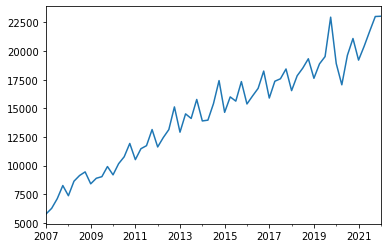

In [446]:
HH_transpose['Расходы на конечное потребление- всего'].plot()

In [448]:
HH_transpose['Time']=HH_transpose.index

In [450]:
HH_transpose.Time

2007Q1    2007Q1
2007Q2    2007Q2
2007Q3    2007Q3
2007Q4    2007Q4
2008Q1    2008Q1
           ...  
2021Q1    2021Q1
2021Q2    2021Q2
2021Q3    2021Q3
2021Q4    2021Q4
2022Q1    2022Q1
Freq: Q-DEC, Name: Time, Length: 61, dtype: period[Q-DEC]

In [473]:
names(HH_transpose)

NameError: name 'names' is not defined

In [489]:
HH_transpose=HH_transpose.rename(columns={'Расходы на конечное потребление- всего':'Total_consumption'})

In [482]:
HH_transpose['numb']=range(len(HH_transpose))

In [490]:
HH_transpose

,Total_consumption,домашнее питание,денежные расходы,стоимость натуральных поступлений продуктов питания,поступлений из личного подсобного хозяйства,полученных подарков и других поступлений,"алкогольные напитки, табачные изделия",одежду и обувь,жилищно-коммунальные услуги и ТОПЛИВО,"предметы домашнего обихода, бытовую технику и уход за домом",...,"стоимость услуг, предоставленных работодателем бесплатно или по льготным ценам",Потребительские расходы- всего,Справочно: из общей суммы расходов на потребление: расходы на питание,расходы на непродовольственные товары,расходы на алкогольные напитки,расходы на оплату услуг,"стоимость услуг, предоставленных работодателем бесплатно или по льготным ценам","финансовые услуги, услуги страхования",Time,numb
2007Q1,5768.200,1939.000000,1627.900000,311.100,255.900000,55.200000,145.300000,518.200000,677.600000,395.100000,...,7.500000,5445.700,NaN,NaN,NaN,NaN,NaN,NaN,2007Q1,0
2007Q2,6254.400,2022.000000,1760.500000,261.500,207.000000,54.500000,141.100000,537.700000,725.700000,391.600000,...,15.100000,5977.400,NaN,NaN,NaN,NaN,NaN,NaN,2007Q2,1
2007Q3,7099.100,2120.700000,1835.700000,285.000,216.200000,68.800000,151.400000,639.400000,845.900000,503.700000,...,13.500000,6830.700,NaN,NaN,NaN,NaN,NaN,NaN,2007Q3,2
2007Q4,8248.500,2462.700000,2126.100000,336.600,272.300000,64.300000,196.500000,1014.500000,795.400000,612.000000,...,10.600000,7909.000,NaN,NaN,NaN,NaN,NaN,NaN,2007Q4,3
2008Q1,7359.200,2483.100000,2115.600000,367.500,295.700000,71.800000,166.500000,693.300000,768.000000,522.400000,...,12.500000,6972.300,NaN,NaN,NaN,NaN,NaN,NaN,2008Q1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021Q1,19212.541,6382.719555,5737.699555,645.020,490.456464,154.563536,285.820901,2605.547848,2043.570796,961.188575,...,36.506077,18514.584,7108.914,6501.451,299.360,5266.310,36.506077,154.915724,2021Q1,56
2021Q2,20419.658,7012.619000,6428.624000,583.995,433.074000,150.921000,569.997000,1378.303000,2226.251000,1065.495000,...,56.722000,19791.086,7496.415,6987.527,292.316,5586.690,56.722000,181.924000,2021Q2,57
2021Q3,21742.005,7105.832000,6412.105000,693.727,487.294000,206.433000,619.041000,1805.618000,2155.801000,1232.345000,...,73.465000,21072.360,7625.406,7802.620,305.049,5935.472,73.465000,195.938000,2021Q3,58
2021Q4,23024.478,7865.368000,7198.082000,667.286,506.799000,160.487000,703.314000,1980.783000,2491.375000,1216.956000,...,48.374000,22427.468,8432.327,8282.488,382.909,5878.416,48.374000,284.445000,2021Q4,59


In [491]:
reg=smf.ols(formula='Total_consumption~numb',data=HH_transpose)
results=reg.fit()

In [492]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      Total_consumption   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     971.9
Date:                Sun, 14 Aug 2022   Prob (F-statistic):           2.38e-38
Time:                        23:04:20   Log-Likelihood:                -512.28
No. Observations:                  61   AIC:                             1029.
Df Residuals:                      59   BIC:                             1033.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7196.7152    276.232     26.053      0.0

In [493]:
acon=results.fittedvalues
HH_transpose['detrended']=HH_transpose['Total_consumption']-acon
HH_transpose['Acon']=acon
HH_transpose.head()

,Total_consumption,домашнее питание,денежные расходы,стоимость натуральных поступлений продуктов питания,поступлений из личного подсобного хозяйства,полученных подарков и других поступлений,"алкогольные напитки, табачные изделия",одежду и обувь,жилищно-коммунальные услуги и ТОПЛИВО,"предметы домашнего обихода, бытовую технику и уход за домом",...,Справочно: из общей суммы расходов на потребление: расходы на питание,расходы на непродовольственные товары,расходы на алкогольные напитки,расходы на оплату услуг,"стоимость услуг, предоставленных работодателем бесплатно или по льготным ценам","финансовые услуги, услуги страхования",Time,numb,detrended,Acon
2007Q1,5768.2,1939.0,1627.9,311.1,255.9,55.2,145.3,518.2,677.6,395.1,...,NaN,NaN,NaN,NaN,NaN,NaN,2007Q1,0,-1428.515195,7196.715195
2007Q2,6254.4,2022.0,1760.5,261.5,207.0,54.5,141.1,537.7,725.7,391.6,...,NaN,NaN,NaN,NaN,NaN,NaN,2007Q2,1,-1189.887257,7444.287257
2007Q3,7099.1,2120.7,1835.7,285.0,216.2,68.8,151.4,639.4,845.9,503.7,...,NaN,NaN,NaN,NaN,NaN,NaN,2007Q3,2,-592.759320,7691.859320
2007Q4,8248.5,2462.7,2126.1,336.6,272.3,64.3,196.5,1014.5,795.4,612.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2007Q4,3,309.068618,7939.431382
2008Q1,7359.2,2483.1,2115.6,367.5,295.7,71.8,166.5,693.3,768.0,522.4,...,NaN,NaN,NaN,NaN,NaN,NaN,2008Q1,4,-827.803445,8187.003445


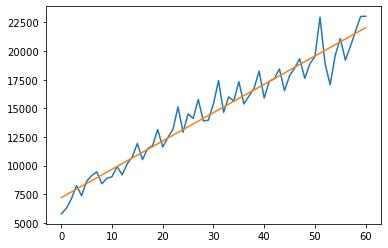

In [494]:
plt.plot("numb","Total_consumption",data=HH_transpose)
plt.plot(HH_transpose["numb"],acon)

In [495]:
HH_transpose=sm.add_constant(HH_transpose)

In [501]:
for i in range(len(HH_transpose.columns)):
    print(i,HH_transpose.columns[i])

0 const
1 Total_consumption
2 домашнее питание
3     денежные расходы
4 стоимость натуральных поступлений продуктов питания
5 поступлений из личного подсобного хозяйства
6 полученных подарков и других поступлений
7 алкогольные напитки, табачные    изделия
8 одежду и обувь
9 жилищно-коммунальные услуги и ТОПЛИВО
10 предметы домашнего обихода,    бытовую технику и уход за домом
11 здравоохранение
12 транспорт
13 связь
14 организацию отдыха и культурные    мероприятия
15 образование
16 гостиницы, кафе и рестораны
17 другие товары и услуги
18 стоимость услуг, предоставленных  работодателем бесплатно или по  льготным ценам
19 Потребительские расходы- всего
20 Справочно: из общей суммы расходов на потребление: расходы на питание
21 расходы на непродовольственные товары
22 расходы на алкогольные напитки
23 расходы на оплату услуг
24 стоимость услуг, предоставленных работодателем бесплатно или по льготным ценам
25 финансовые услуги, услуги страхования
26 Time
27 numb
28 detrended
29 Acon


In [ ]:
HH_transpose=HH_transpose.rename(columns={'домашнее питание':'homemade_food'})
HH_transpose=HH_transpose.rename(columns={"алкогольные напитки, табачные    изделия":"Alcohol_tobacco"})
HH_transpose=HH_transpose.rename(columns={HH_transpose.columns[8]:'clothing_shoes'})

жилищно-коммунальные услуги и ТОПЛИВО

In [503]:
HH_transpose[HH_transpose.columns[0]]

2007Q1    1.0
2007Q2    1.0
2007Q3    1.0
2007Q4    1.0
2008Q1    1.0
         ... 
2021Q1    1.0
2021Q2    1.0
2021Q3    1.0
2021Q4    1.0
2022Q1    1.0
Freq: Q-DEC, Name: const, Length: 61, dtype: float64

In [1406]:
HH_transpose

,const,Total_consumption,домашнее питание,денежные расходы,стоимость натуральных поступлений продуктов питания,поступлений из личного подсобного хозяйства,полученных подарков и других поступлений,"алкогольные напитки, табачные изделия",одежду и обувь,жилищно-коммунальные услуги и ТОПЛИВО,...,Справочно: из общей суммы расходов на потребление: расходы на питание,расходы на непродовольственные товары,расходы на алкогольные напитки,расходы на оплату услуг,"стоимость услуг, предоставленных работодателем бесплатно или по льготным ценам","финансовые услуги, услуги страхования",Time,numb,detrended,Acon
2007Q1,1.0,5768.200,1939.000000,1627.900000,311.100,255.900000,55.200000,145.300000,518.200000,677.600000,...,NaN,NaN,NaN,NaN,NaN,NaN,2007Q1,0,-1428.515195,7196.715195
2007Q2,1.0,6254.400,2022.000000,1760.500000,261.500,207.000000,54.500000,141.100000,537.700000,725.700000,...,NaN,NaN,NaN,NaN,NaN,NaN,2007Q2,1,-1189.887257,7444.287257
2007Q3,1.0,7099.100,2120.700000,1835.700000,285.000,216.200000,68.800000,151.400000,639.400000,845.900000,...,NaN,NaN,NaN,NaN,NaN,NaN,2007Q3,2,-592.759320,7691.859320
2007Q4,1.0,8248.500,2462.700000,2126.100000,336.600,272.300000,64.300000,196.500000,1014.500000,795.400000,...,NaN,NaN,NaN,NaN,NaN,NaN,2007Q4,3,309.068618,7939.431382
2008Q1,1.0,7359.200,2483.100000,2115.600000,367.500,295.700000,71.800000,166.500000,693.300000,768.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,2008Q1,4,-827.803445,8187.003445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021Q1,1.0,19212.541,6382.719555,5737.699555,645.020,490.456464,154.563536,285.820901,2605.547848,2043.570796,...,7108.914,6501.451,299.360,5266.310,36.506077,154.915724,2021Q1,56,-1848.209687,21060.750687
2021Q2,1.0,20419.658,7012.619000,6428.624000,583.995,433.074000,150.921000,569.997000,1378.303000,2226.251000,...,7496.415,6987.527,292.316,5586.690,56.722000,181.924000,2021Q2,57,-888.664749,21308.322749
2021Q3,1.0,21742.005,7105.832000,6412.105000,693.727,487.294000,206.433000,619.041000,1805.618000,2155.801000,...,7625.406,7802.620,305.049,5935.472,73.465000,195.938000,2021Q3,58,186.110189,21555.894811
2021Q4,1.0,23024.478,7865.368000,7198.082000,667.286,506.799000,160.487000,703.314000,1980.783000,2491.375000,...,8432.327,8282.488,382.909,5878.416,48.374000,284.445000,2021Q4,59,1221.011126,21803.466874


In [506]:
equations = OrderedDict()
equations['home-made food'] = {'dependent': HH_transpose[HH_transpose.columns[2]],
                         'exog': HH_transpose[[ 'const','detrended']]}
equations['closing and shoes'] = {'dependent': HH_transpose[HH_transpose.columns[8]],
                         'exog': HH_transpose[[ 'const','detrended']]}
mod = SUR(equations)

In [507]:
print(mod.fit(cov_type='unadjusted'))

                           System GLS Estimation Summary                           
Estimator:                        GLS   Overall R-squared:                   0.0242
No. Equations.:                     2   McElroy's R-squared:                 0.2436
No. Observations:                  61   Judge's (OLS) R-squared:             0.0242
Date:                Sun, Aug 14 2022   Berndt's R-squared:                  0.3918
Time:                        23:19:23   Dhrymes's R-squared:                 0.0242
                                        Cov. Estimator:                  unadjusted
                                        Num. Constraints:                      None
        Equation: home-made food, Dependent Variable: домашнее питание        
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          4732.5     194.72     24.305     0.0000      4350.9      5114.2
detrended   

## Кросс-секционные данные по регионам России за 2020

In [ ]:
https://showdata.gks.ru/report/277338/ - величина прожитоного минимума

Доупустим, суммарная минимальная норма потребления = прожитончому минимуму региона. Поэтому добавляем данные по региональному прожиточному минимуму

In [1329]:
#Получаем сырые данные
Households_crude = pd.read_excel(r'C:\Users\79618\Desktop\(3 курс) Курсовая работа\Data\ДХ ПО РЕГИОНАМ 2020.xlsx',header=0)
Households_crude.head()

,Номер,Регион,"Расходы на потребление - всего (в среднем на члена домохозяйствав месяц, рублей), 2020",ДОМАШНЕЕ ПИТАНИЕ,ДП: денежные расходы,ДП: стоимость натуральных поступлений,СТП: поступлений из дичного подсобного хозяйтсва,СТП: полученных подарков и других поступлений,"АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ",ОДЕЖДУ И ОБУВЬ,...,"ГОСТИНИЦЫ, КАФЕ И РЕСТОРАНЫ",ФИНАНСОВЫЕ УСЛУГИ И УСЛУГИ СТРАХОВАНИЯ,"ЛИЧНАЯ ГИГИЕНА, СОЦИАЛЬНАЯ ЗАЩИТА, ПРОЧИЕ ТОВАРЫ И УСЛУГИ","стоимость услуг, предоставляемых работодателем бесплатно или по льготным ценам","ПРОЖИТОЧНЫЙ МИНИМУМ, 1 кв. 2020 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 2 кв. 2020 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 3 кв. 2020 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 4 кв. 2020 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 2021 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 2022 г."
0,0,Российская Федерация,19180.790,34.984690,31.765829,3.218861,2.305630,0.913226,3.179275,6.687472,...,2.347036,1.000739,5.943375,0.286260,10843.0,11468.0,11605.99,11328.99,11653.0,13918.99
1,1,Центральный федеральный округ,22970.936,33.687900,31.707485,1.980416,1.483701,0.496715,3.415586,6.053698,...,2.716977,1.041385,6.184768,0.288543,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Северо-Западный федеральный округ,22801.269,32.094051,30.699752,1.394300,0.879074,0.515221,3.114270,6.971156,...,3.040712,1.023708,6.079787,0.362396,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Южный федеральный округ,16911.452,38.291331,34.781679,3.509657,2.114419,1.395238,3.104719,6.745530,...,2.740060,0.904356,5.370959,0.096408,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Северо-Кавказский федеральный округ,13264.375,44.074576,39.385806,4.688770,3.746222,0.942547,1.786530,7.768651,...,0.983786,0.873636,5.188512,0.026198,NaN,NaN,NaN,NaN,NaN,NaN


In [1330]:
pd.DataFrame(Households_crude.columns)
#Надо дропнуть 4,5,6,7,21,22,23,25,26

,0
0,Номер
1,Регион
2,Расходы на потребление - всего (в среднем на ч...
3,ДОМАШНЕЕ ПИТАНИЕ
4,ДП: денежные расходы
5,ДП: стоимость натуральных поступлений
6,СТП: поступлений из дичного подсобного хозяйтсва
7,СТП: полученных подарков и других поступлений
8,"АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ"
9,ОДЕЖДУ И ОБУВЬ


In [1331]:
list(Households_crude.columns[[4,5,6,7,21,22,23,25,26]])

['ДП: денежные расходы',
 'ДП: стоимость натуральных поступлений',
 'СТП: поступлений из дичного подсобного хозяйтсва',
 'СТП: полученных подарков и других поступлений',
 'ПРОЖИТОЧНЫЙ МИНИМУМ, 1 кв. 2020 г.',
 'ПРОЖИТОЧНЫЙ МИНИМУМ, 2 кв. 2020 г.',
 'ПРОЖИТОЧНЫЙ МИНИМУМ, 3 кв. 2020 г.',
 'ПРОЖИТОЧНЫЙ МИНИМУМ, 2021 г.',
 'ПРОЖИТОЧНЫЙ МИНИМУМ, 2022 г.']

In [1332]:
#Обрезаем федеральные округа
Households1=Households_crude.drop(columns=list(Households_crude.columns[[4,5,6,7,21,22,23,25,26]]))[9:]
#Мы выявили 3 региона, для которых потребление ниже прожиточного минимума.
#Возможно надо будет исключить эти 3 наблюдения. А именно:
Households1["MINIMA"]=Households1.iloc[:,2]-Households1.iloc[:,-1]
#Удалим из выборки плохие регионы:
Households1 = Households1.loc[Households1['MINIMA'] > 0]
#Получим абсолютные значения
Households_abs=Households1
Households_abs[Households1.columns[3:-2]]=Households1[Households1.columns[3:-2]].multiply(Households1[Households1.columns[2]]/100, axis="index")

In [1333]:
Households_abs.dtypes

Номер                                                                                       int64
Регион                                                                                     object
Расходы на потребление - всего (в среднем на члена домохозяйствав месяц, рублей), 2020    float64
ДОМАШНЕЕ ПИТАНИЕ                                                                          float64
АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ                                                                float64
ОДЕЖДУ И ОБУВЬ                                                                            float64
ЖИЛИЩНЫЕ УСЛУГИ, ВОДА, ГАЗ И ДРУГИЕ ВИДЫ ТОПЛИВА                                          float64
МЕБЕЛЬ, БЫТОВАЯ ТЕХНИКА И ТЕКУЩЕЕ СОДЕРЖАНИЕ ДОМА                                         float64
ЗДРАВООХРАНЕНИЕ                                                                           float64
ТРАНСПОРТ                                                                                 float64
ИНФОРМАЦИЯ И КОММУНИ

In [1336]:
pd.DataFrame(Households_abs.columns)

,0
0,Номер
1,Регион
2,Расходы на потребление - всего (в среднем на ч...
3,ДОМАШНЕЕ ПИТАНИЕ
4,"АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ"
5,ОДЕЖДУ И ОБУВЬ
6,"ЖИЛИЩНЫЕ УСЛУГИ, ВОДА, ГАЗ И ДРУГИЕ ВИДЫ ТОПЛИВА"
7,"МЕБЕЛЬ, БЫТОВАЯ ТЕХНИКА И ТЕКУЩЕЕ СОДЕРЖАНИЕ ДОМА"
8,ЗДРАВООХРАНЕНИЕ
9,ТРАНСПОРТ


In [1335]:
Households_abs1=Households_abs

In [1338]:
Households_abs1['resid']=Households_abs.iloc[:,2]-Households_abs.iloc[:,3:-2].sum(axis=1)

In [1339]:
Households_abs.describe()

,Номер,"Расходы на потребление - всего (в среднем на члена домохозяйствав месяц, рублей), 2020",ДОМАШНЕЕ ПИТАНИЕ,"АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ",ОДЕЖДУ И ОБУВЬ,"ЖИЛИЩНЫЕ УСЛУГИ, ВОДА, ГАЗ И ДРУГИЕ ВИДЫ ТОПЛИВА","МЕБЕЛЬ, БЫТОВАЯ ТЕХНИКА И ТЕКУЩЕЕ СОДЕРЖАНИЕ ДОМА",ЗДРАВООХРАНЕНИЕ,ТРАНСПОРТ,ИНФОРМАЦИЯ И КОММУНИКАЦИЯ,"ОРГАНИЗАЦИЯ ОТДЫХА, СПОРТИВНЫХ И КУЛЬТУРНЫХ МЕРОПРИЯТИЙ",ОБРАЗОВАНИЕ,"ГОСТИНИЦЫ, КАФЕ И РЕСТОРАНЫ",ФИНАНСОВЫЕ УСЛУГИ И УСЛУГИ СТРАХОВАНИЯ,"ЛИЧНАЯ ГИГИЕНА, СОЦИАЛЬНАЯ ЗАЩИТА, ПРОЧИЕ ТОВАРЫ И УСЛУГИ","стоимость услуг, предоставляемых работодателем бесплатно или по льготным ценам","ПРОЖИТОЧНЫЙ МИНИМУМ, 4 кв. 2020 г.",MINIMA,resid
count,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000
mean,49.012658,17829.391354,6477.066544,550.757076,1235.222329,1996.938671,1104.794949,696.745544,2572.802911,601.314848,885.365532,125.898089,308.916165,175.570091,1042.708061,55.290405,11711.674544,6117.716810,0.000139
std,23.824946,4443.818423,1176.368018,229.357343,343.552593,669.364071,345.003609,185.363683,1188.591587,163.889579,446.159436,74.514056,233.115812,70.362613,417.882474,73.111949,2486.687467,2742.860824,0.001047
min,9.000000,11806.421000,3941.208000,91.210000,624.930000,1029.100000,533.569000,175.667000,644.294000,312.475000,89.402000,7.567000,6.671000,57.958192,344.212808,0.000000,9053.000000,1269.290000,-0.002000
25%,28.500000,15245.228500,5823.509500,420.453000,994.509000,1609.489000,886.652500,602.803500,1863.907500,517.571500,578.468000,76.181000,149.208000,133.171286,790.902214,7.339000,10309.995000,4242.450000,-0.001000
50%,49.000000,16778.328000,6380.076000,536.727000,1192.585000,1852.329000,1031.804000,690.619000,2331.746000,558.826000,799.455000,121.984000,249.211000,165.287584,981.640416,28.974000,10816.990000,6053.194000,0.000000
75%,69.500000,18930.572000,6820.269000,674.620000,1347.936500,2241.998000,1195.620000,796.104500,3019.788000,629.489000,1046.108500,160.469500,404.324500,191.401996,1136.733504,63.688500,11945.995000,7485.229500,0.001000
max,89.000000,32223.469000,10383.879000,1318.916000,2258.801000,4397.948000,2441.102000,1226.580000,6286.627000,1216.126000,2420.279000,414.365000,1310.810000,420.994306,2500.278694,372.487000,21524.000000,15196.373000,0.002000


In [1340]:
list(Households_abs1['resid'])

[0.0,
 0.0009999999983847374,
 0.0020000000004074536,
 -5.4569682106375694e-12,
 3.637978807091713e-12,
 0.000999999996565748,
 0.0010000000002037268,
 -3.637978807091713e-12,
 -3.637978807091713e-12,
 0.0010000000074796844,
 0.0,
 -1.8189894035458565e-12,
 0.0020000000004074536,
 0.0009999999983847374,
 0.0,
 0.0,
 0.0009999999983847374,
 -0.00200000001132139,
 -0.0010000000002037268,
 0.000999999996565748,
 -0.000999999996565748,
 -0.0010000000002037268,
 -3.637978807091713e-12,
 -0.000999999996565748,
 3.637978807091713e-12,
 0.0010000000002037268,
 0.0010000000002037268,
 -7.275957614183426e-12,
 3.637978807091713e-12,
 -1.8189894035458565e-12,
 0.0010000000002037268,
 -0.0020000000004074536,
 0.0,
 0.0020000000004074536,
 -0.0010000000038417056,
 -0.000999999996565748,
 0.0,
 0.0020000000004074536,
 -0.0009999999983847374,
 0.0,
 -1.8189894035458565e-12,
 0.000999999996565748,
 1.8189894035458565e-12,
 -0.0010000000038417056,
 -0.0010000000038417056,
 0.0010000000002037268,
 0.000

In [1341]:
bad_goods=pd.DataFrame(Households_abs1.mean()).loc[pd.DataFrame(Households_abs1.mean())[0]<500][1:-1].index
bad_goods

C:\Users\79618\AppData\Local\Temp\ipykernel_17960\681724190.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  bad_goods=pd.DataFrame(Households_abs1.mean()).loc[pd.DataFrame(Households_abs1.mean())[0]<500][1:-1].index


Index(['ОБРАЗОВАНИЕ', 'ГОСТИНИЦЫ, КАФЕ И РЕСТОРАНЫ',
       'ФИНАНСОВЫЕ УСЛУГИ И УСЛУГИ СТРАХОВАНИЯ',
       'стоимость услуг, предоставляемых работодателем бесплатно или по льготным ценам'],
      dtype='object')

In [1342]:
Households_abs1[bad_goods]

,ОБРАЗОВАНИЕ,"ГОСТИНИЦЫ, КАФЕ И РЕСТОРАНЫ",ФИНАНСОВЫЕ УСЛУГИ И УСЛУГИ СТРАХОВАНИЯ,"стоимость услуг, предоставляемых работодателем бесплатно или по льготным ценам"
9,181.247,283.362,159.709823,63.631
10,12.199,384.856,133.390554,33.148
11,88.582,148.642,129.059805,7.520
12,292.399,95.194,156.654477,12.371
13,136.620,251.546,187.693745,50.486
...,...,...,...,...
85,251.874,483.215,265.368654,93.800
86,202.795,64.713,204.623455,3.970
87,53.029,652.384,420.994306,235.747
88,285.596,161.574,256.834120,372.487


In [1343]:
Households_abs1.iloc[:,-5]

9      948.514177
10     792.204446
11     766.484195
12     930.368523
13    1114.710255
         ...     
85    1576.020346
86    1215.255545
87    2500.278694
88    1525.333880
89     981.640416
Name: ЛИЧНАЯ ГИГИЕНА, СОЦИАЛЬНАЯ ЗАЩИТА, ПРОЧИЕ ТОВАРЫ И УСЛУГИ, Length: 79, dtype: float64

In [1344]:
pd.DataFrame(Households_abs1.columns)

,0
0,Номер
1,Регион
2,Расходы на потребление - всего (в среднем на ч...
3,ДОМАШНЕЕ ПИТАНИЕ
4,"АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ"
5,ОДЕЖДУ И ОБУВЬ
6,"ЖИЛИЩНЫЕ УСЛУГИ, ВОДА, ГАЗ И ДРУГИЕ ВИДЫ ТОПЛИВА"
7,"МЕБЕЛЬ, БЫТОВАЯ ТЕХНИКА И ТЕКУЩЕЕ СОДЕРЖАНИЕ ДОМА"
8,ЗДРАВООХРАНЕНИЕ
9,ТРАНСПОРТ


In [1345]:
Households_abs2=Households_abs1

In [1346]:
Households_abs2['OTHER']=Households_abs1[bad_goods].sum(axis=1)+Households_abs1.iloc[:,-5]

In [1347]:
Households_abs2.OTHER

9     1636.464
10    1355.798
11    1140.288
12    1486.987
13    1741.056
        ...   
85    2670.278
86    1691.357
87    3862.433
88    2601.825
89    1552.537
Name: OTHER, Length: 79, dtype: float64

In [1349]:
Households_abs3=Households_abs2.iloc[:,list(range(12))+list(range(17,21))]
Households_abs3

,Номер,Регион,"Расходы на потребление - всего (в среднем на члена домохозяйствав месяц, рублей), 2020",ДОМАШНЕЕ ПИТАНИЕ,"АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ",ОДЕЖДУ И ОБУВЬ,"ЖИЛИЩНЫЕ УСЛУГИ, ВОДА, ГАЗ И ДРУГИЕ ВИДЫ ТОПЛИВА","МЕБЕЛЬ, БЫТОВАЯ ТЕХНИКА И ТЕКУЩЕЕ СОДЕРЖАНИЕ ДОМА",ЗДРАВООХРАНЕНИЕ,ТРАНСПОРТ,ИНФОРМАЦИЯ И КОММУНИКАЦИЯ,"ОРГАНИЗАЦИЯ ОТДЫХА, СПОРТИВНЫХ И КУЛЬТУРНЫХ МЕРОПРИЯТИЙ","ПРОЖИТОЧНЫЙ МИНИМУМ, 4 кв. 2020 г.",MINIMA,resid,OTHER
9,9,Белгородская область,19641.113,7206.479,702.334,1192.585,1768.979,1163.428,694.381,3629.781,594.029,1052.653,9592.99,10048.123,0.000000e+00,1636.464
10,10,Брянская область,15389.084,6527.007,357.904,1150.028,1463.557,943.073,457.425,1986.029,526.166,622.096,10950.00,4439.084,1.000000e-03,1355.798
11,11,Владимирская область,15381.744,6512.052,480.839,1017.065,1871.377,934.542,723.449,1439.613,628.239,634.278,10807.99,4573.754,2.000000e-03,1140.288
12,12,Воронежская область,15489.427,6475.240,686.666,896.190,1838.600,891.103,678.844,1486.029,527.040,522.728,9053.00,6436.427,-5.456968e-12,1486.987
13,13,Ивановская область,18127.078,6379.709,924.488,1272.686,2159.561,1290.922,713.234,2270.249,543.215,831.958,10580.99,7546.088,3.637979e-12,1741.056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,85,Хабаровский край,23689.475,7204.255,673.024,1738.625,2935.928,1657.419,1132.351,3552.634,696.441,1428.518,15569.00,8120.475,2.000000e-03,2670.278
86,86,Амурская область,18844.826,6106.459,488.682,1053.163,2181.356,926.084,1054.711,3839.737,739.387,763.891,13529.99,5314.836,-1.000000e-03,1691.357
87,87,Магаданская область,30866.054,10383.879,676.468,2110.107,4352.638,1919.080,1085.864,3524.473,1216.126,1734.987,20829.99,10036.064,-1.000000e-03,3862.433
88,88,Сахалинская область,28262.529,10062.414,700.047,1821.614,2723.923,1763.421,909.624,5157.369,910.613,1611.678,16130.00,12132.529,1.000000e-03,2601.825


In [1357]:
list(Households_abs3.columns[2:-5])+[Households_abs3.columns[-1]]

['Расходы на потребление - всего (в среднем на члена домохозяйствав месяц, рублей), 2020',
 'ДОМАШНЕЕ ПИТАНИЕ',
 'АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ',
 'ОДЕЖДУ И ОБУВЬ',
 'ЖИЛИЩНЫЕ УСЛУГИ, ВОДА, ГАЗ И ДРУГИЕ ВИДЫ ТОПЛИВА',
 'МЕБЕЛЬ, БЫТОВАЯ ТЕХНИКА И ТЕКУЩЕЕ СОДЕРЖАНИЕ ДОМА',
 'ЗДРАВООХРАНЕНИЕ',
 'ТРАНСПОРТ',
 'ИНФОРМАЦИЯ И КОММУНИКАЦИЯ',
 'OTHER']

In [1374]:
Households_abs3.iloc[:,2]

9     19641.113
10    15389.084
11    15381.744
12    15489.427
13    18127.078
        ...    
85    23689.475
86    18844.826
87    30866.054
88    28262.529
89    18483.121
Name: Расходы на потребление - всего (в среднем на члена домохозяйствав месяц, рублей), 2020, Length: 79, dtype: float64

In [1390]:
Households_abs3.iloc[:,2]-Households_abs3.iloc[:,3:-4].sum(axis=1)-Households_abs3.iloc[:,-1]

9     3.637979e-12
10    1.000000e-03
11    2.000000e-03
12   -6.366463e-12
13    4.547474e-13
          ...     
85    2.000000e-03
86   -1.000000e-03
87   -1.000000e-03
88    1.000000e-03
89    4.547474e-13
Length: 79, dtype: float64

In [1392]:
Households_abs3.mean()

C:\Users\79618\AppData\Local\Temp\ipykernel_17960\2536529923.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Households_abs3.mean()


Номер                                                                                        49.012658
Расходы на потребление - всего (в среднем на члена домохозяйствав месяц, рублей), 2020    17829.391354
ДОМАШНЕЕ ПИТАНИЕ                                                                           6477.066544
АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ                                                                  550.757076
ОДЕЖДУ И ОБУВЬ                                                                             1235.222329
ЖИЛИЩНЫЕ УСЛУГИ, ВОДА, ГАЗ И ДРУГИЕ ВИДЫ ТОПЛИВА                                           1996.938671
МЕБЕЛЬ, БЫТОВАЯ ТЕХНИКА И ТЕКУЩЕЕ СОДЕРЖАНИЕ ДОМА                                          1104.794949
ЗДРАВООХРАНЕНИЕ                                                                             696.745544
ТРАНСПОРТ                                                                                  2572.802911
ИНФОРМАЦИЯ И КОММУНИКАЦИЯ                                                

In [1398]:
Households_abs4=Households_abs3

In [1404]:
Households_abs4.columns=['numb', 'Region',
       'Total_consumption',
       'Food', 'Alcohol_Tobacco', 'Cloth_Shoes',
       'Housing',
       'Furniture_Electronics_House maintenance', 'Healthcare',
       'Transport', 'IT_Communication',
       'Recreation',
       'Cost_of_Living', 'MINIMA', 'resid', 'Other_goods']

In [1405]:
Households_abs4

,numb,Region,Total_consumption,Food,Alcohol_Tobacco,Cloth_Shoes,Housing,Furniture_Electronics_House maintenance,Healthcare,Transport,IT_Communication,Recreation,Cost_of_Living,MINIMA,resid,Other_goods
9,9,Белгородская область,19641.113,7206.479,702.334,1192.585,1768.979,1163.428,694.381,3629.781,594.029,1052.653,9592.99,10048.123,0.000000e+00,1636.464
10,10,Брянская область,15389.084,6527.007,357.904,1150.028,1463.557,943.073,457.425,1986.029,526.166,622.096,10950.00,4439.084,1.000000e-03,1355.798
11,11,Владимирская область,15381.744,6512.052,480.839,1017.065,1871.377,934.542,723.449,1439.613,628.239,634.278,10807.99,4573.754,2.000000e-03,1140.288
12,12,Воронежская область,15489.427,6475.240,686.666,896.190,1838.600,891.103,678.844,1486.029,527.040,522.728,9053.00,6436.427,-5.456968e-12,1486.987
13,13,Ивановская область,18127.078,6379.709,924.488,1272.686,2159.561,1290.922,713.234,2270.249,543.215,831.958,10580.99,7546.088,3.637979e-12,1741.056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,85,Хабаровский край,23689.475,7204.255,673.024,1738.625,2935.928,1657.419,1132.351,3552.634,696.441,1428.518,15569.00,8120.475,2.000000e-03,2670.278
86,86,Амурская область,18844.826,6106.459,488.682,1053.163,2181.356,926.084,1054.711,3839.737,739.387,763.891,13529.99,5314.836,-1.000000e-03,1691.357
87,87,Магаданская область,30866.054,10383.879,676.468,2110.107,4352.638,1919.080,1085.864,3524.473,1216.126,1734.987,20829.99,10036.064,-1.000000e-03,3862.433
88,88,Сахалинская область,28262.529,10062.414,700.047,1821.614,2723.923,1763.421,909.624,5157.369,910.613,1611.678,16130.00,12132.529,1.000000e-03,2601.825


In [ ]:
приступим к оценке

In [1407]:
Households_abs4=sm.add_constant(Households_abs4)

In [1409]:
pd.DataFrame(Households_abs4.columns)

,0
0,const
1,numb
2,Region
3,Total_consumption
4,Food
5,Alcohol_Tobacco
6,Cloth_Shoes
7,Housing
8,Furniture_Electronics_House maintenance
9,Healthcare


In [1506]:
equations = OrderedDict()
#1
equations['home-made food'] = {'dependent': Households_abs4['Food'],
                         'exog': Households_abs4[[ 'const','Total_consumption']]}
#2
equations['Alcohol_Tobacco'] = {'dependent': Households_abs4['Alcohol_Tobacco'],
                         'exog': Households_abs4[[ 'const','Total_consumption']]}
#3
equations['clothing and shoes'] = {'dependent': Households_abs4["Cloth_Shoes"],
                         'exog': Households_abs4[[ 'const','Total_consumption']]}
#4
equations['Housing'] = {'dependent': Households_abs4["Housing"],
                         'exog': Households_abs4[[ 'const','Total_consumption']]}
#5
equations['Furniture_Electronics_House maintenance'] = {'dependent': Households_abs4["Furniture_Electronics_House maintenance"],
                         'exog': Households_abs4[[ 'const','Total_consumption']]}
#6
equations['Healthcare'] = {'dependent': Households_abs4["Healthcare"],
                         'exog': Households_abs4[[ 'const','Total_consumption']]}
#7
equations['Transport'] = {'dependent': Households_abs4["Transport"],
                         'exog': Households_abs4[[ 'const','Total_consumption']]}
#8
equations['IT_Communication'] = {'dependent': Households_abs4["IT_Communication"],
                         'exog': Households_abs4[[ 'const','Total_consumption']]}
#9
equations['Recreation'] = {'dependent': Households_abs4["Recreation"],
                         'exog': Households_abs4[[ 'const','Total_consumption']]}
#10
equations['Other_goods'] = {'dependent': Households_abs4["Other_goods"],
                         'exog': Households_abs4[[ 'const','Total_consumption']]}


mod = SUR(equations)

In [1497]:
equations = OrderedDict()
#1
equations['home-made food'] = {'dependent': Households_abs4['Food'],
                         'exog': Households_abs4[[ 'const','MINIMA']]}
#2
equations['Alcohol_Tobacco'] = {'dependent': Households_abs4['Alcohol_Tobacco'],
                         'exog': Households_abs4[[ 'const','MINIMA']]}
#3
equations['clothing and shoes'] = {'dependent': Households_abs4["Cloth_Shoes"],
                         'exog': Households_abs4[[ 'const','MINIMA']]}
#4
equations['Housing'] = {'dependent': Households_abs4["Housing"],
                         'exog': Households_abs4[[ 'const','MINIMA']]}
#5
equations['Furniture_Electronics_House maintenance'] = {'dependent': Households_abs4["Furniture_Electronics_House maintenance"],
                         'exog': Households_abs4[[ 'const','MINIMA']]}
#6
equations['Healthcare'] = {'dependent': Households_abs4["Healthcare"],
                         'exog': Households_abs4[[ 'const','MINIMA']]}
#7
equations['Transport'] = {'dependent': Households_abs4["Transport"],
                         'exog': Households_abs4[[ 'const','MINIMA']]}
#8
equations['IT_Communication'] = {'dependent': Households_abs4["IT_Communication"],
                         'exog': Households_abs4[[ 'const','MINIMA']]}
#9
equations['Recreation'] = {'dependent': Households_abs4["Recreation"],
                         'exog': Households_abs4[[ 'const','MINIMA']]}
#10
equations['Other_goods'] = {'dependent': Households_abs4["Other_goods"],
                         'exog': Households_abs4[[ 'const','MINIMA']]}


mod = SUR(equations)

In [1496]:
#10
equations['Other_goods'] = {'dependent': Households_abs4["Other_goods"],
                         'exog': Households_abs4[[ 'const','MINIMA']]}

In [1507]:
print(mod.fit(cov_type='unadjusted'))

                           System GLS Estimation Summary                           
Estimator:                        GLS   Overall R-squared:                   0.6483
No. Equations.:                    10   McElroy's R-squared:                 1.0000
No. Observations:                  79   Judge's (OLS) R-squared:             0.6483
Date:                Thu, Aug 18 2022   Berndt's R-squared:                  1.0000
Time:                        09:21:06   Dhrymes's R-squared:                 0.6483
                                        Cov. Estimator:                  unadjusted
                                        Num. Constraints:                      None
                  Equation: home-made food, Dependent Variable: Food                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
const                 2697.1     317.39     8.4977     0.0000      207

In [1520]:
print(mod.fit(cov_type="robust"))

                           System GLS Estimation Summary                           
Estimator:                        GLS   Overall R-squared:                   0.6483
No. Equations.:                    10   McElroy's R-squared:                 1.0000
No. Observations:                  79   Judge's (OLS) R-squared:             0.6483
Date:                Thu, Aug 18 2022   Berndt's R-squared:                  1.0000
Time:                        19:08:04   Dhrymes's R-squared:                 0.6483
                                        Cov. Estimator:                      robust
                                        Num. Constraints:                      None
                  Equation: home-made food, Dependent Variable: Food                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
const                 2697.1     376.80     7.1579     0.0000      195

In [1519]:
mod.fit(cov_type='unadjusted').fitted_values['home-made food']

9     6861.710798
10    5960.123169
11    5958.566817
12    5981.399601
13    6540.679303
         ...     
85    7720.113479
86    6692.868462
87    9241.814024
88    8689.770298
89    6616.173606
Name: home-made food, Length: 79, dtype: float64

In [1516]:
mod.fit(cov_type='unadjusted').resids

,home-made food,Alcohol_Tobacco,clothing and shoes,Housing,Furniture_Electronics_House maintenance,Healthcare,Transport,IT_Communication,Recreation,Other_goods
9,344.768202,82.341916,-152.201322,-474.074757,-51.937119,-54.312079,699.760272,-65.100847,6.759380,-336.003612
10,566.883831,-99.518217,62.309898,-201.714972,-11.743773,-169.187082,-106.211475,2.845332,-47.190477,3.526214
11,553.485183,23.697416,-70.209341,207.102415,-19.825006,97.047659,-651.181269,105.152771,-34.358364,-210.913182
12,493.840399,225.407320,-197.594616,159.693041,-69.862415,49.350947,-625.982126,0.514391,-155.445973,120.079305
13,-160.970303,362.382743,19.434868,122.240046,168.331252,8.010733,-361.460351,-67.556792,-79.835783,-10.576291
...,...,...,...,...,...,...,...,...,...,...
85,-515.858479,-101.751051,149.083712,142.767502,193.985483,267.424454,-175.038331,-91.992932,24.056259,107.321185
86,-586.409462,-100.865260,-243.481580,46.504733,-240.487646,328.880303,1066.609257,105.690443,-211.474556,-164.965150
87,1142.064976,-372.692642,86.685700,584.296801,15.892712,14.889019,-1617.205721,198.473194,-305.112672,252.709019
88,1372.643702,-249.571821,-44.403967,-690.641374,19.767933,-86.600567,528.664635,-23.883601,-197.824441,-628.151962


In [1518]:
mod.fit(cov_type='unadjusted').cov

,home-made food_const,home-made food_Total_consumption,Alcohol_Tobacco_const,Alcohol_Tobacco_Total_consumption,clothing and shoes_const,clothing and shoes_Total_consumption,Housing_const,Housing_Total_consumption,Furniture_Electronics_House maintenance_const,Furniture_Electronics_House maintenance_Total_consumption,Healthcare_const,Healthcare_Total_consumption,Transport_const,Transport_Total_consumption,IT_Communication_const,IT_Communication_Total_consumption,Recreation_const,Recreation_Total_consumption,Other_goods_const,Other_goods_Total_consumption
home-made food_const,100736.212711,-5.323430,-4019.406826,2.123847e-01,3876.184742,-0.204272,-8007.842016,0.422561,349.744911,-1.775591e-02,-5361.591172,2.833917e-01,-65211.054831,3.440784e+00,-737.047150,3.903521e-02,-12344.971233,6.527860e-01,-9353.228029,0.494540
home-made food_Total_consumption,-5.323430,0.000299,0.212390,-1.191082e-05,-0.204829,0.000011,0.422591,-0.000024,-0.018538,1.008239e-06,0.283389,-1.590237e-05,3.446764,-1.931237e-04,0.038868,-2.184273e-06,0.652409,-3.662022e-05,0.494543,-0.000028
Alcohol_Tobacco_const,-4019.406826,0.212390,5115.102187,-2.703061e-01,-823.003408,0.043478,576.267601,-0.030473,216.417207,-1.141234e-02,-126.886025,6.699456e-03,-3487.865426,1.839701e-01,-383.202611,2.024416e-02,1162.105178,-6.139685e-02,1769.049571,-0.093402
Alcohol_Tobacco_Total_consumption,0.212385,-0.000012,-0.270306,1.516046e-05,0.043489,-0.000002,-0.030502,0.000002,-0.011430,6.398829e-07,0.006698,-3.752608e-07,0.184438,-1.032748e-05,0.020245,-1.135148e-06,-0.061409,3.443678e-06,-0.093518,0.000005
clothing and shoes_const,3876.184742,-0.204829,-823.003408,4.348880e-02,9736.373468,-0.514466,-4211.493700,0.222552,998.279420,-5.272044e-02,-639.212113,3.376766e-02,-14731.286420,7.772371e-01,1018.886915,-5.382586e-02,-1154.852058,6.108406e-02,5917.008387,-0.312520
clothing and shoes_Total_consumption,-0.204272,0.000011,0.043478,-2.438087e-06,-0.514466,0.000029,0.222479,-0.000012,-0.052718,2.956110e-06,0.033765,-1.893248e-06,0.777979,-4.357628e-05,-0.053845,3.019074e-06,0.060980,-3.423240e-06,-0.312644,0.000018
Housing_const,-8007.842016,0.422591,576.267601,-3.050224e-02,-4211.493700,0.222479,17774.907911,-0.939431,-1263.626694,6.680922e-02,1185.282053,-6.264693e-02,-11907.496489,6.289193e-01,844.753851,-4.467464e-02,1650.898226,-8.714450e-02,3342.573754,-0.176266
Housing_Total_consumption,0.422561,-0.000024,-0.030473,1.712190e-06,0.222552,-0.000012,-0.939431,0.000053,0.066816,-3.749118e-06,-0.062639,3.513932e-06,0.630107,-3.532190e-05,-0.044633,2.505344e-06,-0.087285,4.890497e-06,-0.176742,0.000010
Furniture_Electronics_House maintenance_const,349.744911,-0.018538,216.417207,-1.143033e-02,998.279420,-0.052718,-1263.626694,0.066816,9925.447253,-5.244118e-01,-1103.259104,5.826980e-02,-12881.989102,6.799977e-01,462.116696,-2.441481e-02,-218.373238,1.159473e-02,3506.371688,-0.185045
Furniture_Electronics_House maintenance_Total_consumption,-0.017756,0.000001,-0.011412,6.398829e-07,-0.052720,0.000003,0.066809,-0.000004,-0.524412,2.940824e-05,0.058263,-3.266370e-06,0.679809,-3.810008e-05,-0.024420,1.369269e-06,0.011511,-6.476746e-07,-0.185180,0.000010


In [1509]:
pars_sur=pd.DataFrame(mod.fit(cov_type='unadjusted').params)
pars_sur

,params
home-made food_const,2697.067401
home-made food_Total_consumption,0.212037
Alcohol_Tobacco_const,-130.956019
Alcohol_Tobacco_Total_consumption,0.038233
clothing and shoes_const,157.328295
clothing and shoes_Total_consumption,0.060458
Housing_const,-425.854972
Housing_Total_consumption,0.135884
Furniture_Electronics_House maintenance_const,11.831582
Furniture_Electronics_House maintenance_Total_consumption,0.061276


In [1511]:
pars_sur[abs(pars_sur['params'])<1]

,params
home-made food_Total_consumption,0.212037
Alcohol_Tobacco_Total_consumption,0.038233
clothing and shoes_Total_consumption,0.060458
Housing_Total_consumption,0.135884
Furniture_Electronics_House maintenance_Total_consumption,0.061276
Healthcare_Total_consumption,0.028711
Transport_Total_consumption,0.197031
IT_Communication_Total_consumption,0.031940
Recreation_Total_consumption,0.088571
Other_goods_Total_consumption,0.145859


In [1514]:
pars_sur[abs(pars_sur['params'])>1].sum()

params   -0.001167
dtype: float64

In [1512]:
pars_sur[abs(pars_sur['params'])<1].sum()

params    1.0
dtype: float64

In [ ]:
Нужно ограничение, потому что сумма получилась меньше 1

In [1488]:
mod.param_names

['home-made food_const',
 'home-made food_MINIMA',
 'Alcohol_Tobacco_const',
 'Alcohol_Tobacco_MINIMA',
 'clothing and shoes_const',
 'clothing and shoes_MINIMA',
 'Housing_const',
 'Housing_MINIMA',
 'Furniture_Electronics_House maintenance_const',
 'Furniture_Electronics_House maintenance_MINIMA',
 'Healthcare_const',
 'Healthcare_MINIMA',
 'Transport_const',
 'Transport_MINIMA',
 'IT_Communication_const',
 'IT_Communication_MINIMA',
 'Recreation_const',
 'Recreation_MINIMA',
 'Other_goods_const',
 'Other_goods_MINIMA']

In [ ]:
r = pd.DataFrame(
    columns=mod.param_names,
    index=["rest{0}".format(i) for i in range(8)],
    dtype=np.float64,
)
r.loc[:, :] = 0.0
r.iloc[:, 6] = -1.0
r.iloc[:, 13::7] = np.eye(8)
print(r.iloc[:, 6::7])

In [1490]:
Households_abs4

,const,numb,Region,Total_consumption,Food,Alcohol_Tobacco,Cloth_Shoes,Housing,Furniture_Electronics_House maintenance,Healthcare,Transport,IT_Communication,Recreation,Cost_of_Living,MINIMA,resid,Other_goods
9,1.0,9,Белгородская область,19641.113,7206.479,702.334,1192.585,1768.979,1163.428,694.381,3629.781,594.029,1052.653,9592.99,10048.123,0.000000e+00,1636.464
10,1.0,10,Брянская область,15389.084,6527.007,357.904,1150.028,1463.557,943.073,457.425,1986.029,526.166,622.096,10950.00,4439.084,1.000000e-03,1355.798
11,1.0,11,Владимирская область,15381.744,6512.052,480.839,1017.065,1871.377,934.542,723.449,1439.613,628.239,634.278,10807.99,4573.754,2.000000e-03,1140.288
12,1.0,12,Воронежская область,15489.427,6475.240,686.666,896.190,1838.600,891.103,678.844,1486.029,527.040,522.728,9053.00,6436.427,-5.456968e-12,1486.987
13,1.0,13,Ивановская область,18127.078,6379.709,924.488,1272.686,2159.561,1290.922,713.234,2270.249,543.215,831.958,10580.99,7546.088,3.637979e-12,1741.056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,1.0,85,Хабаровский край,23689.475,7204.255,673.024,1738.625,2935.928,1657.419,1132.351,3552.634,696.441,1428.518,15569.00,8120.475,2.000000e-03,2670.278
86,1.0,86,Амурская область,18844.826,6106.459,488.682,1053.163,2181.356,926.084,1054.711,3839.737,739.387,763.891,13529.99,5314.836,-1.000000e-03,1691.357
87,1.0,87,Магаданская область,30866.054,10383.879,676.468,2110.107,4352.638,1919.080,1085.864,3524.473,1216.126,1734.987,20829.99,10036.064,-1.000000e-03,3862.433
88,1.0,88,Сахалинская область,28262.529,10062.414,700.047,1821.614,2723.923,1763.421,909.624,5157.369,910.613,1611.678,16130.00,12132.529,1.000000e-03,2601.825


In [1489]:
import statsmodels.formula.api as smf

In [1491]:
reg=smf.ols(formula='Food~Total_consumption	',data=Households_abs4)
ress=reg.fit()

In [1492]:
ress.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Food   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     150.6
Date:                Thu, 18 Aug 2022   Prob (F-statistic):           8.40e-20
Time:                        08:42:43   Log-Likelihood:                -627.33
No. Observations:                  79   AIC:                             1259.
Df Residuals:                      77   BIC:                             1263.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          2637.8547    322.314      8.184      0.000    1996.046    3279.663
Total_consumption     0.2153      0.018     12.271      0.000       0.180       0.250
==============================================================================
Omnibus:                        9.475   Durbin-Watson:                   1.560
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                9.361
Skew:                           0.713   Prob(JB):                      0.00928
Kurtosis:                       3.901   Cond. No.                     7.64e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.64e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

-------

In [ ]:
Теперь надо установить соответсвие эконометрической теории

# Лишнее

Проверим на то, что каждый прожиточный минимум ниже расходов на потребление

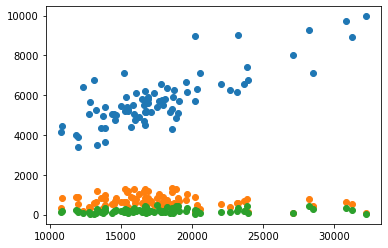

In [1141]:
plt.scatter(Households4.iloc[:,2],Households4.iloc[:,4])
plt.scatter(Households4.iloc[:,2],Households4.iloc[:,5])
plt.scatter(Households4.iloc[:,2],Households4.iloc[:,7])

In [1143]:
Households4=Households4.rename(columns={'Номер': "numb"})
Households4.head()

,numb,Регион,"Расходы на потребление - всего (в среднем на члена домохозяйствав месяц, рублей), 2020",ДОМАШНЕЕ ПИТАНИЕ,ДП: денежные расходы,ДП: стоимость натуральных поступлений,СТП: поступлений из дичного подсобного хозяйтсва,СТП: полученных подарков и других поступлений,"АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ",ОДЕЖДУ И ОБУВЬ,...,ФИНАНСОВЫЕ УСЛУГИ И УСЛУГИ СТРАХОВАНИЯ,"ЛИЧНАЯ ГИГИЕНА, СОЦИАЛЬНАЯ ЗАЩИТА, ПРОЧИЕ ТОВАРЫ И УСЛУГИ","стоимость услуг, предоставляемых работодателем бесплатно или по льготным ценам","ПРОЖИТОЧНЫЙ МИНИМУМ, 1 кв. 2020 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 2 кв. 2020 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 3 кв. 2020 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 4 кв. 2020 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 2021 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 2022 г.",MINIMA
9,9,Белгородская область,19641.113,7206.479,6152.661,1053.818,709.746,344.072,702.334,1192.585,...,159.709823,948.514177,63.631,9236.0,9382.00,9395.00,9592.99,9720.00,11691.99,9921.113
10,10,Брянская область,15389.084,6527.007,5391.810,1135.197,930.147,205.049,357.904,1150.028,...,133.390554,792.204446,33.148,10537.0,11280.00,11341.99,10950.00,11280.00,13127.00,4109.084
11,11,Владимирская область,15381.744,6512.052,5882.779,629.273,480.900,148.374,480.839,1017.065,...,129.059805,766.484195,7.520,10280.0,11092.99,11178.00,10807.99,11092.99,13501.00,4288.754
12,12,Воронежская область,15489.427,6475.240,5315.575,1159.665,958.520,201.145,686.666,896.190,...,156.654477,930.368523,12.371,8894.0,9362.00,9269.00,9053.00,9747.00,11831.99,5742.427
13,13,Ивановская область,18127.078,6379.709,5810.276,569.433,416.571,152.862,924.488,1272.686,...,187.693745,1114.710255,50.486,10123.0,10760.99,10965.00,10580.99,10760.99,12806.00,7366.088


In [1144]:
Households4.numb=range(79)

ValueError: Length of values (79) does not match length of index (82)

In [865]:
Households4.index=range(79)

In [866]:
Households4

,numb,Регион,"Расходы на потребление - всего (в среднем на члена домохозяйствав месяц, рублей), 2020",ДОМАШНЕЕ ПИТАНИЕ,ДП: денежные расходы,ДП: стоимость натуральных поступлений,СТП: поступлений из дичного подсобного хозяйтсва,СТП: полученных подарков и других поступлений,"АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ",ОДЕЖДУ И ОБУВЬ,...,ФИНАНСОВЫЕ УСЛУГИ И УСЛУГИ СТРАХОВАНИЯ,"ЛИЧНАЯ ГИГИЕНА, СОЦИАЛЬНАЯ ЗАЩИТА, ПРОЧИЕ ТОВАРЫ И УСЛУГИ","стоимость услуг, предоставляемых работодателем бесплатно или по льготным ценам","ПРОЖИТОЧНЫЙ МИНИМУМ, 1 кв. 2020 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 2 кв. 2020 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 3 кв. 2020 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 4 кв. 2020 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 2021 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 2022 г.",MINIMA
0,0,Белгородская область,19641.113,7206.479,6152.661,1053.818,709.746,344.072,702.334,1192.585,...,159.709823,948.514177,63.631,9236.00,9382.00,9395.00,9592.99,9720.00,11691.99,10048.123
1,1,Брянская область,15389.084,6527.007,5391.810,1135.197,930.147,205.049,357.904,1150.028,...,133.390554,792.204446,33.148,10537.00,11280.00,11341.99,10950.00,11280.00,13127.00,4439.084
2,2,Владимирская область,15381.744,6512.052,5882.779,629.273,480.900,148.374,480.839,1017.065,...,129.059805,766.484195,7.520,10280.00,11092.99,11178.00,10807.99,11092.99,13501.00,4573.754
3,3,Воронежская область,15489.427,6475.240,5315.575,1159.665,958.520,201.145,686.666,896.190,...,156.654477,930.368523,12.371,8894.00,9362.00,9269.00,9053.00,9747.00,11831.99,6436.427
4,4,Ивановская область,18127.078,6379.709,5810.276,569.433,416.571,152.862,924.488,1272.686,...,187.693745,1114.710255,50.486,10123.00,10760.99,10965.00,10580.99,10760.99,12806.00,7546.088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,74,Хабаровский край,23689.475,7204.255,6539.595,664.661,473.241,191.420,673.024,1738.625,...,265.368654,1576.020346,93.800,14771.00,15319.99,15569.00,15569.00,16221.99,18557.99,8120.475
75,75,Амурская область,18844.826,6106.459,4834.320,1272.140,851.574,420.566,488.682,1053.163,...,204.623455,1215.255545,3.970,12525.00,12949.99,13280.99,13529.99,14016.99,16174.00,5314.836
76,76,Магаданская область,30866.054,10383.879,9743.896,639.983,310.061,329.922,676.468,2110.107,...,420.994306,2500.278694,235.747,19996.99,20588.00,21101.99,20829.99,21101.99,24219.99,10036.064
77,77,Сахалинская область,28262.529,10062.414,9282.030,780.384,355.926,424.459,700.047,1821.614,...,256.834120,1525.333880,372.487,15211.99,15905.99,16408.00,16130.00,15905.99,18930.00,12132.529


In [867]:
Households4=Households4.rename(columns={Households4.columns[2]: "Total_consumption"})
Households4

,numb,Регион,Total_consumption,ДОМАШНЕЕ ПИТАНИЕ,ДП: денежные расходы,ДП: стоимость натуральных поступлений,СТП: поступлений из дичного подсобного хозяйтсва,СТП: полученных подарков и других поступлений,"АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ",ОДЕЖДУ И ОБУВЬ,...,ФИНАНСОВЫЕ УСЛУГИ И УСЛУГИ СТРАХОВАНИЯ,"ЛИЧНАЯ ГИГИЕНА, СОЦИАЛЬНАЯ ЗАЩИТА, ПРОЧИЕ ТОВАРЫ И УСЛУГИ","стоимость услуг, предоставляемых работодателем бесплатно или по льготным ценам","ПРОЖИТОЧНЫЙ МИНИМУМ, 1 кв. 2020 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 2 кв. 2020 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 3 кв. 2020 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 4 кв. 2020 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 2021 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 2022 г.",MINIMA
0,0,Белгородская область,19641.113,7206.479,6152.661,1053.818,709.746,344.072,702.334,1192.585,...,159.709823,948.514177,63.631,9236.00,9382.00,9395.00,9592.99,9720.00,11691.99,10048.123
1,1,Брянская область,15389.084,6527.007,5391.810,1135.197,930.147,205.049,357.904,1150.028,...,133.390554,792.204446,33.148,10537.00,11280.00,11341.99,10950.00,11280.00,13127.00,4439.084
2,2,Владимирская область,15381.744,6512.052,5882.779,629.273,480.900,148.374,480.839,1017.065,...,129.059805,766.484195,7.520,10280.00,11092.99,11178.00,10807.99,11092.99,13501.00,4573.754
3,3,Воронежская область,15489.427,6475.240,5315.575,1159.665,958.520,201.145,686.666,896.190,...,156.654477,930.368523,12.371,8894.00,9362.00,9269.00,9053.00,9747.00,11831.99,6436.427
4,4,Ивановская область,18127.078,6379.709,5810.276,569.433,416.571,152.862,924.488,1272.686,...,187.693745,1114.710255,50.486,10123.00,10760.99,10965.00,10580.99,10760.99,12806.00,7546.088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,74,Хабаровский край,23689.475,7204.255,6539.595,664.661,473.241,191.420,673.024,1738.625,...,265.368654,1576.020346,93.800,14771.00,15319.99,15569.00,15569.00,16221.99,18557.99,8120.475
75,75,Амурская область,18844.826,6106.459,4834.320,1272.140,851.574,420.566,488.682,1053.163,...,204.623455,1215.255545,3.970,12525.00,12949.99,13280.99,13529.99,14016.99,16174.00,5314.836
76,76,Магаданская область,30866.054,10383.879,9743.896,639.983,310.061,329.922,676.468,2110.107,...,420.994306,2500.278694,235.747,19996.99,20588.00,21101.99,20829.99,21101.99,24219.99,10036.064
77,77,Сахалинская область,28262.529,10062.414,9282.030,780.384,355.926,424.459,700.047,1821.614,...,256.834120,1525.333880,372.487,15211.99,15905.99,16408.00,16130.00,15905.99,18930.00,12132.529


In [892]:
good_goods=[]
bad_goods=[]
for i in range(len(Households4.mean())):
    if Households4.mean()[i]<500:
        x='!!!!!!!!!!!'
        bad_goods.append(i)
    else:
        x=''
        good_goods.append(i)
    print(i,Households4.mean().index[i],Households4.mean()[i],x)

C:\Users\79618\AppData\Local\Temp\ipykernel_17960\1422788337.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  for i in range(len(Households4.mean())):
C:\Users\79618\AppData\Local\Temp\ipykernel_17960\1422788337.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  if Households4.mean()[i]<500:
C:\Users\79618\AppData\Local\Temp\ipykernel_17960\1422788337.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(i,Households4.mean().index[i],Households4.mean()[i],x)


0 numb 39.0 !!!!!!!!!!!
1 Total_consumption 17829.391354430383 
2 ДОМАШНЕЕ ПИТАНИЕ 6477.0665443038 
3 ДП: денежные расходы 5773.59740506329 
4 ДП: стоимость натуральных поступлений 703.4691518987343 
5 СТП: поступлений из дичного подсобного хозяйтсва 507.4170759493671 
6 СТП: полученных подарков и других поступлений 196.05218987341775 !!!!!!!!!!!
7 АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ 550.757075949367 
8 ОДЕЖДУ И ОБУВЬ 1235.2223291139244 
9 ЖИЛИЩНЫЕ УСЛУГИ, ВОДА, ГАЗ И ДРУГИЕ ВИДЫ ТОПЛИВА 1996.9386708860766 
10 МЕБЕЛЬ, БЫТОВАЯ ТЕХНИКА И ТЕКУЩЕЕ СОДЕРЖАНИЕ ДОМА 1104.794949367089 
11 ЗДРАВООХРАНЕНИЕ 696.7455443037979 
12 ТРАНСПОРТ 2572.8029113924053 
13 ИНФОРМАЦИЯ И КОММУНИКАЦИЯ 601.3148481012659 
14 ОРГАНИЗАЦИЯ ОТДЫХА, СПОРТИВНЫХ И КУЛЬТУРНЫХ МЕРОПРИЯТИЙ 885.3655316455697 
15 ОБРАЗОВАНИЕ
 125.89808860759494 !!!!!!!!!!!
16 ГОСТИНИЦЫ, КАФЕ И РЕСТОРАНЫ 308.9161645569619 !!!!!!!!!!!
17 ФИНАНСОВЫЕ УСЛУГИ И УСЛУГИ СТРАХОВАНИЯ 175.57009059432852 !!!!!!!!!!!
18 ЛИЧНАЯ ГИГИЕНА, СОЦИАЛЬНАЯ ЗАЩИТА, ПРОЧИЕ Т

Все товара с потреблением ниже 500 агрегируются в 1 благо "остальное"

In [908]:
Households4['other']=Households4.iloc[:,16]+Households4.iloc[:,17]+Households4.iloc[:,18]+Households4.iloc[:,19]+Households4.iloc[:,20]

In [923]:
for i in range(len(Households4.columns)):
    print(i,Households4.columns[i])

0 numb
1 Регион
2 Total_consumption
3 ДОМАШНЕЕ ПИТАНИЕ
4 ДП: денежные расходы
5 ДП: стоимость натуральных поступлений
6 СТП: поступлений из дичного подсобного хозяйтсва
7 СТП: полученных подарков и других поступлений
8 АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ
9 ОДЕЖДУ И ОБУВЬ
10 ЖИЛИЩНЫЕ УСЛУГИ, ВОДА, ГАЗ И ДРУГИЕ ВИДЫ ТОПЛИВА
11 МЕБЕЛЬ, БЫТОВАЯ ТЕХНИКА И ТЕКУЩЕЕ СОДЕРЖАНИЕ ДОМА
12 ЗДРАВООХРАНЕНИЕ
13 ТРАНСПОРТ
14 ИНФОРМАЦИЯ И КОММУНИКАЦИЯ
15 ОРГАНИЗАЦИЯ ОТДЫХА, СПОРТИВНЫХ И КУЛЬТУРНЫХ МЕРОПРИЯТИЙ
16 ОБРАЗОВАНИЕ

17 ГОСТИНИЦЫ, КАФЕ И РЕСТОРАНЫ
18 ФИНАНСОВЫЕ УСЛУГИ И УСЛУГИ СТРАХОВАНИЯ
19 ЛИЧНАЯ ГИГИЕНА, СОЦИАЛЬНАЯ ЗАЩИТА, ПРОЧИЕ ТОВАРЫ И УСЛУГИ
20 стоимость услуг, предоставляемых работодателем бесплатно или по льготным ценам
21 ПРОЖИТОЧНЫЙ МИНИМУМ, 1 кв. 2020 г.
22 ПРОЖИТОЧНЫЙ МИНИМУМ, 2 кв. 2020 г.
23 ПРОЖИТОЧНЫЙ МИНИМУМ, 3 кв. 2020 г.
24 ПРОЖИТОЧНЫЙ МИНИМУМ, 4 кв. 2020 г.
25 ПРОЖИТОЧНЫЙ МИНИМУМ, 2021 г.
26 ПРОЖИТОЧНЫЙ МИНИМУМ, 2022 г.
27 MINIMA
28 other


In [1016]:
pd.DataFrameHouseholds4.mean()

C:\Users\79618\AppData\Local\Temp\ipykernel_17960\3384389577.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Households4.mean()


numb                                                                                 39.000000
Total_consumption                                                                 17829.391354
ДОМАШНЕЕ ПИТАНИЕ                                                                   6477.066544
ДП: денежные расходы                                                               5773.597405
ДП: стоимость натуральных поступлений                                               703.469152
СТП: поступлений из дичного подсобного хозяйтсва                                    507.417076
СТП: полученных подарков и других поступлений                                       196.052190
АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ                                                          550.757076
ОДЕЖДУ И ОБУВЬ                                                                     1235.222329
ЖИЛИЩНЫЕ УСЛУГИ, ВОДА, ГАЗ И ДРУГИЕ ВИДЫ ТОПЛИВА                                   1996.938671
МЕБЕЛЬ, БЫТОВАЯ ТЕХНИКА И ТЕКУЩЕЕ СОДЕРЖАНИЕ ДОМА 

In [1026]:
xxxxxx=pd.DataFrame(Households4.columns)["1"]=Households4.mean()

C:\Users\79618\AppData\Local\Temp\ipykernel_17960\3379030880.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  xxxxxx=pd.DataFrame(Households4.columns)["1"]=Households4.mean()


In [1029]:
xxxxxx=pd.DataFrame(xxxxxx)

In [1031]:
xxxxxx

,0
numb,39.000000
Total_consumption,17829.391354
ДОМАШНЕЕ ПИТАНИЕ,6477.066544
ДП: денежные расходы,5773.597405
ДП: стоимость натуральных поступлений,703.469152
СТП: поступлений из дичного подсобного хозяйтсва,507.417076
СТП: полученных подарков и других поступлений,196.052190
"АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ",550.757076
ОДЕЖДУ И ОБУВЬ,1235.222329
"ЖИЛИЩНЫЕ УСЛУГИ, ВОДА, ГАЗ И ДРУГИЕ ВИДЫ ТОПЛИВА",1996.938671


In [1033]:
xxxxxx['n']=range(len(xxxxxx))

In [1038]:
xxxxxx['-']=xxxxxx[0]-500

In [1042]:
xxxxxx.loc[xxxxxx['-']>500]['n']

Total_consumption                                             1
ДОМАШНЕЕ ПИТАНИЕ                                              2
ДП: денежные расходы                                          3
ОДЕЖДУ И ОБУВЬ                                                8
ЖИЛИЩНЫЕ УСЛУГИ, ВОДА, ГАЗ И ДРУГИЕ ВИДЫ ТОПЛИВА              9
МЕБЕЛЬ, БЫТОВАЯ ТЕХНИКА И ТЕКУЩЕЕ СОДЕРЖАНИЕ ДОМА            10
ТРАНСПОРТ                                                    12
ЛИЧНАЯ ГИГИЕНА, СОЦИАЛЬНАЯ ЗАЩИТА, ПРОЧИЕ ТОВАРЫ И УСЛУГИ    18
ПРОЖИТОЧНЫЙ МИНИМУМ, 1 кв. 2020 г.                           20
ПРОЖИТОЧНЫЙ МИНИМУМ, 2 кв. 2020 г.                           21
ПРОЖИТОЧНЫЙ МИНИМУМ, 3 кв. 2020 г.                           22
ПРОЖИТОЧНЫЙ МИНИМУМ, 4 кв. 2020 г.                           23
ПРОЖИТОЧНЫЙ МИНИМУМ, 2021 г.                                 24
ПРОЖИТОЧНЫЙ МИНИМУМ, 2022 г.                                 25
MINIMA                                                       26
other                                   

In [1044]:
lll=list(xxxxxx.loc[xxxxxx['-']>500]['n'])

In [1048]:
lll=[0]+lll

In [1051]:
lll[0:-7]

[0, 1, 2, 3, 8, 9, 10, 12, 18, 20]

In [1100]:
Households5=Households4.iloc[:,[0, 1, 2, 3, 8, 9, 10,11, 12,13,14,15, 24,27,28]]
Households5

,numb,Регион,Total_consumption,ДОМАШНЕЕ ПИТАНИЕ,"АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ",ОДЕЖДУ И ОБУВЬ,"ЖИЛИЩНЫЕ УСЛУГИ, ВОДА, ГАЗ И ДРУГИЕ ВИДЫ ТОПЛИВА","МЕБЕЛЬ, БЫТОВАЯ ТЕХНИКА И ТЕКУЩЕЕ СОДЕРЖАНИЕ ДОМА",ЗДРАВООХРАНЕНИЕ,ТРАНСПОРТ,ИНФОРМАЦИЯ И КОММУНИКАЦИЯ,"ОРГАНИЗАЦИЯ ОТДЫХА, СПОРТИВНЫХ И КУЛЬТУРНЫХ МЕРОПРИЯТИЙ","ПРОЖИТОЧНЫЙ МИНИМУМ, 4 кв. 2020 г.",MINIMA,other
0,0,Белгородская область,19641.113,7206.479,702.334,1192.585,1768.979,1163.428,694.381,3629.781,594.029,1052.653,9592.99,10048.123,1636.464
1,1,Брянская область,15389.084,6527.007,357.904,1150.028,1463.557,943.073,457.425,1986.029,526.166,622.096,10950.00,4439.084,1355.798
2,2,Владимирская область,15381.744,6512.052,480.839,1017.065,1871.377,934.542,723.449,1439.613,628.239,634.278,10807.99,4573.754,1140.288
3,3,Воронежская область,15489.427,6475.240,686.666,896.190,1838.600,891.103,678.844,1486.029,527.040,522.728,9053.00,6436.427,1486.987
4,4,Ивановская область,18127.078,6379.709,924.488,1272.686,2159.561,1290.922,713.234,2270.249,543.215,831.958,10580.99,7546.088,1741.056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,74,Хабаровский край,23689.475,7204.255,673.024,1738.625,2935.928,1657.419,1132.351,3552.634,696.441,1428.518,15569.00,8120.475,2670.278
75,75,Амурская область,18844.826,6106.459,488.682,1053.163,2181.356,926.084,1054.711,3839.737,739.387,763.891,13529.99,5314.836,1691.357
76,76,Магаданская область,30866.054,10383.879,676.468,2110.107,4352.638,1919.080,1085.864,3524.473,1216.126,1734.987,20829.99,10036.064,3862.433
77,77,Сахалинская область,28262.529,10062.414,700.047,1821.614,2723.923,1763.421,909.624,5157.369,910.613,1611.678,16130.00,12132.529,2601.825


In [1072]:
Households5.iloc[:,2]

0     19641.113
1     15389.084
2     15381.744
3     15489.427
4     18127.078
        ...    
74    23689.475
75    18844.826
76    30866.054
77    28262.529
78    18483.121
Name: Total_consumption, Length: 79, dtype: float64

In [1074]:
Households5.iloc[:,2]-Households5.iloc[:,3]

0     12434.634
1      8862.077
2      8869.692
3      9014.187
4     11747.369
        ...    
74    16485.220
75    12738.367
76    20482.175
77    18200.115
78    12818.014
Length: 79, dtype: float64

In [1101]:
pd.DataFrame(Households5.columns)

,0
0,numb
1,Регион
2,Total_consumption
3,ДОМАШНЕЕ ПИТАНИЕ
4,"АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ"
5,ОДЕЖДУ И ОБУВЬ
6,"ЖИЛИЩНЫЕ УСЛУГИ, ВОДА, ГАЗ И ДРУГИЕ ВИДЫ ТОПЛИВА"
7,"МЕБЕЛЬ, БЫТОВАЯ ТЕХНИКА И ТЕКУЩЕЕ СОДЕРЖАНИЕ ДОМА"
8,ЗДРАВООХРАНЕНИЕ
9,ТРАНСПОРТ


In [1102]:
Households5

,numb,Регион,Total_consumption,ДОМАШНЕЕ ПИТАНИЕ,"АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ",ОДЕЖДУ И ОБУВЬ,"ЖИЛИЩНЫЕ УСЛУГИ, ВОДА, ГАЗ И ДРУГИЕ ВИДЫ ТОПЛИВА","МЕБЕЛЬ, БЫТОВАЯ ТЕХНИКА И ТЕКУЩЕЕ СОДЕРЖАНИЕ ДОМА",ЗДРАВООХРАНЕНИЕ,ТРАНСПОРТ,ИНФОРМАЦИЯ И КОММУНИКАЦИЯ,"ОРГАНИЗАЦИЯ ОТДЫХА, СПОРТИВНЫХ И КУЛЬТУРНЫХ МЕРОПРИЯТИЙ","ПРОЖИТОЧНЫЙ МИНИМУМ, 4 кв. 2020 г.",MINIMA,other
0,0,Белгородская область,19641.113,7206.479,702.334,1192.585,1768.979,1163.428,694.381,3629.781,594.029,1052.653,9592.99,10048.123,1636.464
1,1,Брянская область,15389.084,6527.007,357.904,1150.028,1463.557,943.073,457.425,1986.029,526.166,622.096,10950.00,4439.084,1355.798
2,2,Владимирская область,15381.744,6512.052,480.839,1017.065,1871.377,934.542,723.449,1439.613,628.239,634.278,10807.99,4573.754,1140.288
3,3,Воронежская область,15489.427,6475.240,686.666,896.190,1838.600,891.103,678.844,1486.029,527.040,522.728,9053.00,6436.427,1486.987
4,4,Ивановская область,18127.078,6379.709,924.488,1272.686,2159.561,1290.922,713.234,2270.249,543.215,831.958,10580.99,7546.088,1741.056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,74,Хабаровский край,23689.475,7204.255,673.024,1738.625,2935.928,1657.419,1132.351,3552.634,696.441,1428.518,15569.00,8120.475,2670.278
75,75,Амурская область,18844.826,6106.459,488.682,1053.163,2181.356,926.084,1054.711,3839.737,739.387,763.891,13529.99,5314.836,1691.357
76,76,Магаданская область,30866.054,10383.879,676.468,2110.107,4352.638,1919.080,1085.864,3524.473,1216.126,1734.987,20829.99,10036.064,3862.433
77,77,Сахалинская область,28262.529,10062.414,700.047,1821.614,2723.923,1763.421,909.624,5157.369,910.613,1611.678,16130.00,12132.529,2601.825


In [1103]:
z1=Households5.iloc[:,0:3]

In [1104]:
z1

,numb,Регион,Total_consumption
0,0,Белгородская область,19641.113
1,1,Брянская область,15389.084
2,2,Владимирская область,15381.744
3,3,Воронежская область,15489.427
4,4,Ивановская область,18127.078
...,...,...,...
74,74,Хабаровский край,23689.475
75,75,Амурская область,18844.826
76,76,Магаданская область,30866.054
77,77,Сахалинская область,28262.529


In [1105]:
pd.DataFrame(Households5.columns)

,0
0,numb
1,Регион
2,Total_consumption
3,ДОМАШНЕЕ ПИТАНИЕ
4,"АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ"
5,ОДЕЖДУ И ОБУВЬ
6,"ЖИЛИЩНЫЕ УСЛУГИ, ВОДА, ГАЗ И ДРУГИЕ ВИДЫ ТОПЛИВА"
7,"МЕБЕЛЬ, БЫТОВАЯ ТЕХНИКА И ТЕКУЩЕЕ СОДЕРЖАНИЕ ДОМА"
8,ЗДРАВООХРАНЕНИЕ
9,ТРАНСПОРТ


In [1106]:

for i in [3,4,5,6,7,8,9,10,11,14]:
    if i==3:
        z1[3]=Households5.iloc[:,2]-Households5.iloc[:,i]
    z1[i]=z1[3]-Households5.iloc[:,i]

In [1107]:
z1

,numb,Регион,Total_consumption,3,4,5,6,7,8,9,10,11,14
0,0,Белгородская область,19641.113,5228.155,4525.821,4035.570,3459.176,4064.727,4533.774,1598.374,4634.126,4175.502,3591.691
1,1,Брянская область,15389.084,2335.070,1977.166,1185.042,871.513,1391.997,1877.645,349.041,1808.904,1712.974,979.272
2,2,Владимирская область,15381.744,2357.640,1876.801,1340.575,486.263,1423.098,1634.191,918.027,1729.401,1723.362,1217.352
3,3,Воронежская область,15489.427,2538.947,1852.281,1642.757,700.347,1647.844,1860.103,1052.918,2011.907,2016.219,1051.960
4,4,Ивановская область,18127.078,5367.660,4443.172,4094.974,3208.099,4076.738,4654.426,3097.411,4824.445,4535.702,3626.604
...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,74,Хабаровский край,23689.475,9280.965,8607.941,7542.340,6345.037,7623.546,8148.614,5728.331,8584.524,7852.447,6610.687
75,75,Амурская область,18844.826,6631.908,6143.226,5578.745,4450.552,5705.824,5577.197,2792.171,5892.521,5868.017,4940.551
76,76,Магаданская область,30866.054,10098.296,9421.828,7988.189,5745.658,8179.216,9012.432,6573.823,8882.170,8363.309,6235.863
77,77,Сахалинская область,28262.529,8137.701,7437.654,6316.087,5413.778,6374.280,7228.077,2980.332,7227.088,6526.023,5535.876


In [1093]:
Households5.iloc[:,[3,4,5,6,7,10]]

,ДОМАШНЕЕ ПИТАНИЕ,"АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ",ОДЕЖДУ И ОБУВЬ,"ЖИЛИЩНЫЕ УСЛУГИ, ВОДА, ГАЗ И ДРУГИЕ ВИДЫ ТОПЛИВА",ЗДРАВООХРАНЕНИЕ,other
0,7206.479,702.334,1192.585,1768.979,694.381,1636.464
1,6527.007,357.904,1150.028,1463.557,457.425,1355.798
2,6512.052,480.839,1017.065,1871.377,723.449,1140.288
3,6475.240,686.666,896.190,1838.600,678.844,1486.987
4,6379.709,924.488,1272.686,2159.561,713.234,1741.056
...,...,...,...,...,...,...
74,7204.255,673.024,1738.625,2935.928,1132.351,2670.278
75,6106.459,488.682,1053.163,2181.356,1054.711,1691.357
76,10383.879,676.468,2110.107,4352.638,1085.864,3862.433
77,10062.414,700.047,1821.614,2723.923,909.624,2601.825


In [1021]:
pd.DataFrame(Households4.columns).join(pd.DataFrame(Households4.mean()))

C:\Users\79618\AppData\Local\Temp\ipykernel_17960\1980495938.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pd.DataFrame(Households4.columns).join(pd.DataFrame(Households4.mean()))


ValueError: columns overlap but no suffix specified: RangeIndex(start=0, stop=1, step=1)

In [1015]:
pd.merge(Households4.mean(),Households4.columns)

C:\Users\79618\AppData\Local\Temp\ipykernel_17960\2702506861.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pd.merge(Households4.mean(),Households4.columns)


ValueError: Cannot merge a Series without a name

In [1009]:
Households00

[Index(['numb', 'Регион', 'Total_consumption', 'ДОМАШНЕЕ ПИТАНИЕ',
        'ДП: денежные расходы', 'ДП: стоимость натуральных поступлений',
        'СТП: поступлений из дичного подсобного хозяйтсва',
        'СТП: полученных подарков и других поступлений',
        'АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ', 'ОДЕЖДУ И ОБУВЬ',
        'ЖИЛИЩНЫЕ УСЛУГИ, ВОДА, ГАЗ И ДРУГИЕ ВИДЫ ТОПЛИВА',
        'МЕБЕЛЬ, БЫТОВАЯ ТЕХНИКА И ТЕКУЩЕЕ СОДЕРЖАНИЕ ДОМА', 'ЗДРАВООХРАНЕНИЕ',
        'ТРАНСПОРТ', 'ИНФОРМАЦИЯ И КОММУНИКАЦИЯ',
        'ОРГАНИЗАЦИЯ ОТДЫХА, СПОРТИВНЫХ И КУЛЬТУРНЫХ МЕРОПРИЯТИЙ',
        'ОБРАЗОВАНИЕ\n', 'ГОСТИНИЦЫ, КАФЕ И РЕСТОРАНЫ',
        'ФИНАНСОВЫЕ УСЛУГИ И УСЛУГИ СТРАХОВАНИЯ',
        'ЛИЧНАЯ ГИГИЕНА, СОЦИАЛЬНАЯ ЗАЩИТА, ПРОЧИЕ ТОВАРЫ И УСЛУГИ',
        'стоимость услуг, предоставляемых работодателем бесплатно или по льготным ценам',
        'ПРОЖИТОЧНЫЙ МИНИМУМ, 1 кв. 2020 г.',
        'ПРОЖИТОЧНЫЙ МИНИМУМ, 2 кв. 2020 г.',
        'ПРОЖИТОЧНЫЙ МИНИМУМ, 3 кв. 2020 г.',
        'ПРОЖИТОЧНЫЙ МИНИМУ

In [1004]:
pd.DataFrame(Households4.columns,columns=[1])

,1
0,numb
1,Регион
2,Total_consumption
3,ДОМАШНЕЕ ПИТАНИЕ
4,ДП: денежные расходы
5,ДП: стоимость натуральных поступлений
6,СТП: поступлений из дичного подсобного хозяйтсва
7,СТП: полученных подарков и других поступлений
8,"АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ"
9,ОДЕЖДУ И ОБУВЬ


In [990]:
list(range(0,4))+list(range(21,22))

[0, 1, 2, 3, 21]

In [986]:
good_columns=range(0,4)+range(21,)

C:\Users\79618\AppData\Local\Temp\ipykernel_17960\3384389577.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Households4.mean()


numb                                                                                 39.000000
Total_consumption                                                                 17829.391354
ДОМАШНЕЕ ПИТАНИЕ                                                                   6477.066544
ДП: денежные расходы                                                               5773.597405
ДП: стоимость натуральных поступлений                                               703.469152
СТП: поступлений из дичного подсобного хозяйтсва                                    507.417076
СТП: полученных подарков и других поступлений                                       196.052190
АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ                                                          550.757076
ОДЕЖДУ И ОБУВЬ                                                                     1235.222329
ЖИЛИЩНЫЕ УСЛУГИ, ВОДА, ГАЗ И ДРУГИЕ ВИДЫ ТОПЛИВА                                   1996.938671
МЕБЕЛЬ, БЫТОВАЯ ТЕХНИКА И ТЕКУЩЕЕ СОДЕРЖАНИЕ ДОМА 

In [977]:
Households4.iloc[:[0,1,2,3,4,5,6,7,8,9]]

TypeError: cannot do positional indexing on RangeIndex with these indexers [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]] of type list

In [931]:
Households3.loc[Households3.columns > 0]

,Номер,Регион,"Расходы на потребление - всего (в среднем на члена домохозяйствав месяц, рублей), 2020",ДОМАШНЕЕ ПИТАНИЕ,ДП: денежные расходы,ДП: стоимость натуральных поступлений,СТП: поступлений из дичного подсобного хозяйтсва,СТП: полученных подарков и других поступлений,"АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ",ОДЕЖДУ И ОБУВЬ,...,ФИНАНСОВЫЕ УСЛУГИ И УСЛУГИ СТРАХОВАНИЯ,"ЛИЧНАЯ ГИГИЕНА, СОЦИАЛЬНАЯ ЗАЩИТА, ПРОЧИЕ ТОВАРЫ И УСЛУГИ","стоимость услуг, предоставляемых работодателем бесплатно или по льготным ценам","ПРОЖИТОЧНЫЙ МИНИМУМ, 1 кв. 2020 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 2 кв. 2020 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 3 кв. 2020 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 4 кв. 2020 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 2021 г.","ПРОЖИТОЧНЫЙ МИНИМУМ, 2022 г.",MINIMA
9,9,Белгородская область,19641.113,7206.479,6152.661,1053.818,709.746,344.072,702.334,1192.585,...,159.709823,948.514177,63.631,9236.00,9382.00,9395.00,9592.99,9720.00,11691.99,10048.123
10,10,Брянская область,15389.084,6527.007,5391.810,1135.197,930.147,205.049,357.904,1150.028,...,133.390554,792.204446,33.148,10537.00,11280.00,11341.99,10950.00,11280.00,13127.00,4439.084
11,11,Владимирская область,15381.744,6512.052,5882.779,629.273,480.900,148.374,480.839,1017.065,...,129.059805,766.484195,7.520,10280.00,11092.99,11178.00,10807.99,11092.99,13501.00,4573.754
12,12,Воронежская область,15489.427,6475.240,5315.575,1159.665,958.520,201.145,686.666,896.190,...,156.654477,930.368523,12.371,8894.00,9362.00,9269.00,9053.00,9747.00,11831.99,6436.427
13,13,Ивановская область,18127.078,6379.709,5810.276,569.433,416.571,152.862,924.488,1272.686,...,187.693745,1114.710255,50.486,10123.00,10760.99,10965.00,10580.99,10760.99,12806.00,7546.088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,85,Хабаровский край,23689.475,7204.255,6539.595,664.661,473.241,191.420,673.024,1738.625,...,265.368654,1576.020346,93.800,14771.00,15319.99,15569.00,15569.00,16221.99,18557.99,8120.475
86,86,Амурская область,18844.826,6106.459,4834.320,1272.140,851.574,420.566,488.682,1053.163,...,204.623455,1215.255545,3.970,12525.00,12949.99,13280.99,13529.99,14016.99,16174.00,5314.836
87,87,Магаданская область,30866.054,10383.879,9743.896,639.983,310.061,329.922,676.468,2110.107,...,420.994306,2500.278694,235.747,19996.99,20588.00,21101.99,20829.99,21101.99,24219.99,10036.064
88,88,Сахалинская область,28262.529,10062.414,9282.030,780.384,355.926,424.459,700.047,1821.614,...,256.834120,1525.333880,372.487,15211.99,15905.99,16408.00,16130.00,15905.99,18930.00,12132.529


In [891]:
bad_goods

[0, 6, 15, 16, 17, 19]

In [875]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(Households4.describe())

            numb  Total_consumption  ДОМАШНЕЕ ПИТАНИЕ  ДП: денежные расходы  \
count  79.000000          79.000000         79.000000             79.000000   
mean   39.000000       17829.391354       6477.066544           5773.597405   
std    22.949219        4443.818423       1176.368018           1291.448705   
min     0.000000       11806.421000       3941.208000           3407.203000   
25%    19.500000       15245.228500       5823.509500           5055.073500   
50%    39.000000       16778.328000       6380.076000           5605.658000   
75%    58.500000       18930.572000       6820.269000           6243.488000   
max    78.000000       32223.469000      10383.879000           9964.440000   

       ДП: стоимость натуральных поступлений  \
count                              79.000000   
mean                              703.469152   
std                               306.145423   
min                                68.193000   
25%                               525.957500   


In [869]:
Households4.columns

Index(['numb', 'Регион', 'Total_consumption', 'ДОМАШНЕЕ ПИТАНИЕ',
       'ДП: денежные расходы', 'ДП: стоимость натуральных поступлений',
       'СТП: поступлений из дичного подсобного хозяйтсва',
       'СТП: полученных подарков и других поступлений',
       'АЛКОГОЛЬ, ТАБАК, НАРКОТИКИ', 'ОДЕЖДУ И ОБУВЬ',
       'ЖИЛИЩНЫЕ УСЛУГИ, ВОДА, ГАЗ И ДРУГИЕ ВИДЫ ТОПЛИВА',
       'МЕБЕЛЬ, БЫТОВАЯ ТЕХНИКА И ТЕКУЩЕЕ СОДЕРЖАНИЕ ДОМА', 'ЗДРАВООХРАНЕНИЕ',
       'ТРАНСПОРТ', 'ИНФОРМАЦИЯ И КОММУНИКАЦИЯ',
       'ОРГАНИЗАЦИЯ ОТДЫХА, СПОРТИВНЫХ И КУЛЬТУРНЫХ МЕРОПРИЯТИЙ',
       'ОБРАЗОВАНИЕ\n', 'ГОСТИНИЦЫ, КАФЕ И РЕСТОРАНЫ',
       'ФИНАНСОВЫЕ УСЛУГИ И УСЛУГИ СТРАХОВАНИЯ',
       'ЛИЧНАЯ ГИГИЕНА, СОЦИАЛЬНАЯ ЗАЩИТА, ПРОЧИЕ ТОВАРЫ И УСЛУГИ',
       'стоимость услуг, предоставляемых работодателем бесплатно или по льготным ценам',
       'ПРОЖИТОЧНЫЙ МИНИМУМ, 1 кв. 2020 г.',
       'ПРОЖИТОЧНЫЙ МИНИМУМ, 2 кв. 2020 г.',
       'ПРОЖИТОЧНЫЙ МИНИМУМ, 3 кв. 2020 г.',
       'ПРОЖИТОЧНЫЙ МИНИМУМ, 4 кв. 2020 г.'

In [731]:
xxx=Households3.iloc[:,2]-Households3.iloc[:,3]-Households3.iloc[:,8]-Households3.iloc[:,9]
xxx.mean()

9471.496317073172

In [711]:
reg=smf.ols(formula='Total_consumption~numb',data=Households3)
results=reg.fit()

In [712]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Total_consumption   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.757
Date:                Tue, 16 Aug 2022   Prob (F-statistic):              0.189
Time:                        21:53:11   Log-Likelihood:                -805.38
No. Observations:                  82   AIC:                             1615.
Df Residuals:                      80   BIC:                             1620.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.659e+04    988.139     16.793      0.000    1.46e+04    1.86e+04
numb          27.9238     21.065      1.326      0.189     -13.997      69.844
==============================================================================
Omnibus:                       22.614   Durbin-Watson:                   1.436
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.082
Skew:                           1.238   Prob(JB):                     1.78e-07
Kurtosis:                       4.723   Cond. No.                         93.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [722]:
results.fittedvalues

Int64Index([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
            26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
            43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
            60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76,
            77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90],
           dtype='int64')

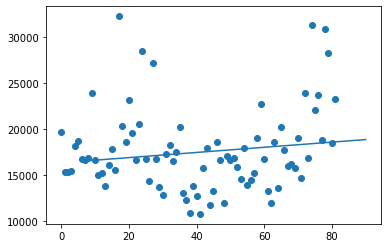

In [723]:
results.fittedvalues.plot()
plt.scatter(range(len(results.fittedvalues)),Households3.Total_consumption)

In [ ]:
Допустим параметр Фриша=-2

Доупустим, суммарная минимальная норма потребления = прожитончому минимуму региона.

Тогда мы можем построить SUR. 

### Модель с ценами